In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

Couldn't import dot_parser, loading of dot files will not be possible.


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
%matplotlib inline

In [3]:
from detect_intermediates import *
from interpret_tICs import *

we are operating on biox3


In [4]:
from mor_h8_protein_ligand_feature_types import *
from get_variable_names import *
from mor_h8_protein_ligand_tica_config import *
from residue import Residue, Atom
from mor_h8_feature_types import feature_name_residues_dict


[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,

In [5]:
#feature_name = "bp_residues_4dkl_5c1m_restricted_pairs"
rho = 0.05
rho_string = "_rho0pt05-normalized"

feature_name = "bp_residues_4dkl_5c1m_restricted_pairs_10A"
#rho = 0.0025
#rho_string = "_rho0pt0025-normalized"

lag_time=50
n_clusters=1000
n_components=10

In [6]:
feature_name

'bp_residues_4dkl_5c1m_restricted_pairs_10A'

In [7]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A
/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A


In [8]:
ligand_residue = Residue(resSeq=900, chain_id="L", res_name="LIG")

In [9]:
active_crystal = md.load_frame([t for t in get_trajectory_files(traj_dir, traj_ext) if "bu72" in t][0], index=0)
ligand = [r for r in active_crystal.topology.residues if "LIG" in str(r)][0]
ligand_atom_names = [a.name for a in ligand.atoms if "H" not in a.name]
print(ligand_atom_names)

[u'C6', u'C7', u'C8', u'C9', u'C10', u'C11', u'C23', u'C24', u'C25', u'C26', u'C27', u'C28', u'C1', u'C2', u'N1', u'C3', u'C4', u'C5', u'O1', u'C12', u'C13', u'N2', u'C14', u'O2', u'C15', u'C16', u'C17', u'C18', u'C19', u'C20', u'C21', u'C22']


In [10]:
#ligand_atom_names = ["N1", "O1", "C7", "C17", "O2", "N2", "C26"]
ligand_atoms = []
for atom_name in ligand_atom_names:
    ligand_atoms.append(Atom(resSeq=900, chain_id="L", atom_name=atom_name, res_name="LIG"))

In [11]:
user_specified_atom_residue_pairs = [x for x in itertools.product(ligand_atoms, bp_residue_objects)]
user_specified_atom_residue_pairs = [ContactFeature(pair[0], pair[1]) for pair in user_specified_atom_residue_pairs]

In [12]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
protein_file = "/home/enf/md_simulations/MOR/mor_active_bu72_h8/ionized.pdb"
refined_atom_residue_pairs = compute_atom_residue_pairs_under_cutoff(ligand_atoms, bp_residue_objects, protein_file, cutoff=1., all_lig_atoms=True)

In [13]:
refined_atom_residue_pairs

[(LIG-C6, TRP318),
 (LIG-C6, CYS321),
 (LIG-C6, ILE322),
 (LIG-C6, ALA323),
 (LIG-C6, LEU324),
 (LIG-C6, GLY325),
 (LIG-C6, TYR326),
 (LIG-C6, ILE198),
 (LIG-C6, LEU219),
 (LIG-C6, LEU232),
 (LIG-C6, LYS233),
 (LIG-C6, VAL236),
 (LIG-C6, PHE237),
 (LIG-C6, ALA240),
 (LIG-C6, PHE241),
 (LIG-C6, CYS292),
 (LIG-C6, TRP293),
 (LIG-C6, THR294),
 (LIG-C6, PRO295),
 (LIG-C6, ILE296),
 (LIG-C6, HIS297),
 (LIG-C6, ILE298),
 (LIG-C6, TYR299),
 (LIG-C6, VAL300),
 (LIG-C6, ILE301),
 (LIG-C6, TYR148),
 (LIG-C6, ASN150),
 (LIG-C6, MET151),
 (LIG-C6, PHE152),
 (LIG-C6, ILE155),
 (LIG-C6, ILE144),
 (LIG-C6, ASP147),
 (LIG-C6, THR120),
 (LIG-C6, GLN124),
 (LIG-C7, TRP318),
 (LIG-C7, CYS321),
 (LIG-C7, ILE322),
 (LIG-C7, ALA323),
 (LIG-C7, LEU324),
 (LIG-C7, GLY325),
 (LIG-C7, TYR326),
 (LIG-C7, ILE198),
 (LIG-C7, LEU232),
 (LIG-C7, LYS233),
 (LIG-C7, ILE234),
 (LIG-C7, CYS235),
 (LIG-C7, VAL236),
 (LIG-C7, PHE237),
 (LIG-C7, ILE238),
 (LIG-C7, PHE239),
 (LIG-C7, ALA240),
 (LIG-C7, PHE241),
 (LIG-C7, CY

In [14]:
refined_atom_residue_pairs = [ContactFeature(pair[0], pair[1]) for pair in refined_atom_residue_pairs]
print(len(refined_atom_residue_pairs))


1023


In [24]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

Waiting for connection file: /vspdata/vspcompute/home/enf/.ipython/profile_default/security/ipcontroller-client.json


IOError: Connection file '/vspdata/vspcompute/home/enf/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

In [25]:
len(refined_atom_residue_pairs)

1023

In [ ]:
if not os.path.exists(features_dir): os.makedirs(features_dir)
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
import time
#time.sleep(60*120)
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs=refined_atom_residue_pairs, worker_pool=None, excluded_trajs=["apo", "oxy", "suf"])

In [15]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
new_features_dir = "%s/reduced_features" %features_dir
if not os.path.exists(new_features_dir):
    os.makedirs(new_features_dir)
new_features_file = "%s/reduced_features.dataset" %new_features_dir
new_features_pkl = "%s/reduced_feature_names.pkl" %new_features_dir
#retain_features_within_range(features_dir, feature_residues_pkl, 0.5,
#                             0.1, new_features_file, new_features_pkl, worker_pool=dview)

In [16]:
with open(new_features_pkl) as f:
    new_feature_names = pickle.load(f)
    feature_residues = new_feature_names
print(new_feature_names)
print(len(new_feature_names))

[Lig900-C6 to Gly325, Lig900-C6 to Met151, Lig900-C6 to Trp293, Lig900-C6 to Ile296, Lig900-C7 to Gly325, Lig900-C7 to Met151, Lig900-C7 to Val236, Lig900-C7 to Trp293, Lig900-C7 to Ile296, Lig900-C7 to His297, Lig900-C7 to Val300, Lig900-C8 to Gly325, Lig900-C8 to Met151, Lig900-C8 to Val236, Lig900-C8 to Trp293, Lig900-C8 to Ile296, Lig900-C8 to His297, Lig900-C8 to Val300, Lig900-C9 to Met151, Lig900-C9 to Tyr148, Lig900-C9 to Lys233, Lig900-C9 to Val236, Lig900-C9 to Trp293, Lig900-C9 to Ile296, Lig900-C9 to His297, Lig900-C9 to Val300, Lig900-C10 to Met151, Lig900-C10 to Tyr148, Lig900-C10 to Val236, Lig900-C10 to Ile296, Lig900-C10 to His297, Lig900-C10 to Val300, Lig900-C11 to Met151, Lig900-C11 to Tyr148, Lig900-C11 to Ile296, Lig900-C23 to Ile144, Lig900-C23 to Asp147, Lig900-C23 to Gln124, Lig900-C24 to Cys217, Lig900-C24 to Trp318, Lig900-C24 to Ile144, Lig900-C24 to Gln124, Lig900-C25 to Cys217, Lig900-C25 to Thr218, Lig900-C25 to Leu219, Lig900-C25 to Trp318, Lig900-C25 to

In [17]:
ref_receptors_dir = "/home/enf/md_simulations/MOR/bu72_ref_receptors" 
ref_features_dir = "%s/bu72_ref_receptors" %features_dir
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
featurize_contacts_custom(ref_receptors_dir, features_dir = ref_features_dir, traj_ext = ".pdb", contact_residue_pairs_file = feature_residues_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = new_feature_names, worker_pool=None, schemes=[])

already featurized
already featurized


UnboundLocalError: local variable 'structure_contact_residue_pairs' referenced before assignment

In [18]:
import pickle
with open(new_features_pkl, "rb") as f:
    feature_residues = pickle.load(f)

In [19]:
feature_residues[:10]

[Lig900-C6 to Gly325,
 Lig900-C6 to Met151,
 Lig900-C6 to Trp293,
 Lig900-C6 to Ile296,
 Lig900-C7 to Gly325,
 Lig900-C7 to Met151,
 Lig900-C7 to Val236,
 Lig900-C7 to Trp293,
 Lig900-C7 to Ile296,
 Lig900-C7 to His297]

In [81]:
#os.system("rm -rf %s" % tica_dir)
#lag_time = 5
#n_components = 5
#sparse = True
#wolf = True
#rho = 0.0025
#shrinkage = None
#traj_ext = ".h5"
import custom_tica
reload(custom_tica)
from custom_tica import *
#fit_normalizer(features_dir, features=load_file(new_features_file))
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=False, features=load_file(new_features_file))

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/reduced_features/reduced_features.dataset
loading "/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/normalizer.h5"...
loading feature files
(453, 158)
[ 0.73431963  0.42081335  0.52990299  0.44012162  0.74012935  0.37679616
  0.42538396  0.4988648   0.43525121  0.35573593]
(512,)
fitting data to tICA model

/vspdata/vspcompute/home/enf/software/msmbuilder_enf/msmbuilder/decomposition/tica.py:396: UserWarning: length of data (28) is too short for the lag time (50)
  warnings.warn("length of data (%d) is too short for the lag time (%d)" % (len(X), self.lag_time))
/vspdata/vspcompute/home/enf/software/msmbuilder_enf/msmbuilder/decomposition/tica.py:396: UserWarning: length of data (29) is too short for the lag time (50)
  warnings.warn("length of data (%d) is too short for the lag time (%d)" % (len(X), self.lag_time))
/vspdata/vspcompute/home/enf/software/msmbuilder_enf/msmbuilder/decomposition/tica.py:396: UserWarning: length of data (32) is too short for the lag time (50)
  warnings.warn("length of data (%d) is too short for the lag time (%d)" % (len(X), self.lag_time))



transformed data with tICA model
Sparse time-structure based Independent Components Analysis (tICA)
------------------------------------------------------------------
n_components        : 10
shrinkage           : 3.22557122682e-05
lag_time            : 50
weighted_transform  : False
rho                 : 0.1
n_features          : 158

Top 5 timescales :
[ 453.80116655  371.46814229  361.13640324  294.80388053  172.41569478]

Top 5 eigenvalues :
[ 0.89567253  0.87406455  0.87070518  0.84399874  0.74826596]

Number of active degrees of freedom:
[4/158, 2/158, 3/158, 5/158, 5/158]

Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt1-normalized/phi_psi_chi2_allprot_tica_coords.h5"... (<class 'msmbuilder.decomposition.sparsetica.SparseTICA'>)
saved tICA model
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A

In [31]:
import custom_tica
reload(custom_tica)
from custom_tica import *
if not os.path.exists(ref_features_dir):
    os.makedirs(ref_features_dir)
transform(existing_model = projection_operator_dir, features_directory = ref_features_dir, tica_dir = ref_tica_dir, normalizer=verboseload("%s/normalizer.h5" %features_dir))

loading "/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/normalizer.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_tica_coords.h5"...
None
None
['/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_aligned_4DKL_R_L.dataset', '/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_ionized_pymol_RL.dataset']
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_aligned_4DKL_R_L.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_ionized_pymol_RL.dataset


In [20]:
tica_object = verboseload(projection_operator_dir)
tica_object.timescales_

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_tica_coords.h5"...


array([ 495.01387945,  481.81564338,  392.08565491,  304.86356991,
        197.00075377,  153.93370155,  122.62525211,  108.47723675,
         93.23733288,   84.72655529])

In [21]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_components_dir = tica_dir
important_contact_features, all_tIC_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, new_features_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(3, 7)
residue_importances_df.shape
(5, 3)
          feature_name      res_i   res_j  resid_i  resid_j  importance  \
1  Lig900-O1 To Trp293  Lig900-O1  Trp293      900      293    0.731784   
2  Lig900-O2 To Cys321  Lig900-O2  Cys321      900      321    0.495822   
0  Lig900-C6 To Trp293  Lig900-C6  Trp293      900      293   -0.495320   

               feature  
1  Lig900-O1 to Trp293  
2  Lig900-O2 to Cys321  
0  Lig900-C6 to Trp293  
Using dark_background
             residue  importance  resid
Lig900-O1  Lig900-O1    0.731784    900
Trp293        Trp293    0.670429    293
Cys321        Cys321    0.495822    321
Lig900-O2  Lig900-O2    0.495822    900
Lig900-C6  Lig900-C6   -0.495320    900
Using dark_background
Interpreting tIC 2
feature_importances_df.shape
(4, 7)
residue_importances_df.shape
(6, 3)
           feature_name       res_i   res_j  resid_i  resid_j  importance  \
1  Lig900-C25 To Trp133  Lig900-C25  Trp133      900    

In [22]:
tic_subsampled_features_file= "%s/features_subsampled.pkl" % tica_dir



In [23]:
len(feature_residues)

158

In [24]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

print tic_subsampled_features_file
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)
important_contact_features_pruned, important_contact_features_indices = find_non_zero_features(important_contact_features, feature_residues)
#subsample_features(features_dir, important_contact_features_indices, important_contact_features_pruned, tic_subsampled_features_file, features=load_file(new_features_file))

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/features_subsampled.pkl


In [25]:
tica_coords = verboseload(projected_features_dir)
print(np.shape(np.concatenate(tica_coords)))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_projected.h5"...
(248499, 10)


In [38]:
import analysis
reload(analysis)
from analysis import *
plot_columns(tica_dir, projected_features_dir, titles = ["BU72_tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_projected.h5"...
()
None
Done plotting columns


In [87]:
bu72_trajs = []
apo_trajs = []
#trajs = [t for t in get_trajectory_files(traj_dir, traj_ext) if "apo_reimaged" not in t and "oxy" not in t]
trajs = [t for t in get_trajectory_files(traj_dir, traj_ext)]
for i, traj in enumerate(trajs):
    if "bu72" in traj:
        bu72_trajs.append(i)
    elif "apo" in traj:
        apo_trajs.append(i)

user_defined_coords = load_file(user_defined_features_file)

            

loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5"...


In [27]:
#pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025"
pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01"

In [28]:
protein_tica_file = "%s/phi_psi_chi2_allprot_projected.h5" %pp_tica_dir
protein_tica = verboseload(protein_tica_file)
protein_tica_bu72 = [protein_tica[i] for i in bu72_trajs]

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/phi_psi_chi2_allprot_projected.h5"...


In [29]:
len(bu72_trajs)

512

In [30]:
protein_tica_bu72_conc = np.concatenate(protein_tica_bu72)
ligand_tica_bu72_conc =  np.concatenate(verboseload(projected_features_dir))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_projected.h5"...


In [31]:
import plots
reload(plots)
from plots import *

#plot_data_vs_data(protein_tica_bu72_conc, ligand_tica_bu72_conc, ["mOR_tIC%d" %i for i in range(1,n_components+1)], ["BU72_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [32]:
n_clusters = 1000
clusterer_dir = "%s/bu72clusterer_%dclusters.h5" % (tica_dir, n_clusters)
#cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters, clusterer_dir)

In [ ]:
import custom_msm
reload(custom_msm)
from custom_msm import *
plot_timescales(clusterer_dir, n_clusters, tica_dir, main="", lag_times=list(range(1,51,10)))

In [ ]:
lag_time = 30
msm_model_dir = "%s/msm_lag_time%d.h5" % (tica_dir, lag_time)
if not os.path.exists(msm_model_dir):
    build_msm(clusterer_dir, lag_time=lag_time, msm_model_dir=msm_model_dir)

In [33]:
import msmbuilder 
reload(msmbuilder)
import msm_resampled
reload(msm_resampled)
from msm_resampled import *

In [34]:
'%s/bu72_clusterer1000.h5' %pp_tica_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/bu72_clusterer1000.h5'

In [74]:
pp_msm_lag_time=50
bu72_pp_resampled_traj_to_frames_file = "%s/bu72_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time)
bu72_pp_resampled_traj_to_frames = verboseload(bu72_pp_resampled_traj_to_frames_file)
bu72_pp_msm_file = "%s/bu72_msm_lag-time%d_prior-counts0.0_clusters1000.h5" %(pp_tica_dir, pp_msm_lag_time)
bu72_pp_msm = verboseload(bu72_pp_msm_file)
bu72_pp_clusterer = verboseload('%s/bu72_clusterer1000.h5' %pp_tica_dir)
bu72_pp_clusters_map = make_clusters_map(bu72_pp_clusterer)
bu72_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
bu72_pp_tic_components_dir = "%s" %pp_tica_dir
bu72_pp_tica_dir = bu72_pp_tic_components_dir
bu72_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
pp_tic_subsampled_features = "%s/features_subsampled.pkl" %pp_tica_dir
bu72_pp_tica = verboseload("%s/bu72_tica_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time))
bu72_pp_pnas_file = "%s/bu72_pnas_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time)
bu72_pp_pnas = verboseload(bu72_pp_pnas_file)
bu72_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
bu72_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/bu72_msm_lag-time50_prior-counts0.0_clusters1000_resampled_10000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/bu72_msm_lag-time50_prior-counts0.0_clusters1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/bu72_clusterer1000.h5"...
34
2109
0
285
1
76
400
155
0
0
307
679
0
19
1600
0
0
508
0
489
93
0
719
2
1
2
38
19
0
10
1123
0
2224
24
292
87
127
77
382
1202
0
1755
209
300
0
26
509
0
55
0
0
2
88
4
106
50
0
0
1
4
114
55
2336
1
24
0
0
0
105
73
0
863
0
3
836
281
595
0
0
29
697
45
183
51
467
141
1554
49
861
0
0
29
340
585
0
179
14
181
774
3
996
888
0
236
1241
101
0
17
14
404
0
86
312
377
9
467
184

In [93]:
pp_msm_lag_time=50
apo_pp_resampled_traj_to_frames_file = "%s/apo_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time)
apo_pp_resampled_traj_to_frames = verboseload(apo_pp_resampled_traj_to_frames_file)
apo_pp_msm_file = "%s/apo_msm_lag-time%d_prior-counts0.0_clusters1000.h5" %(pp_tica_dir, pp_msm_lag_time)
apo_pp_msm = verboseload(apo_pp_msm_file)
apo_pp_clusterer = verboseload('%s/apo_clusterer1000.h5' %pp_tica_dir)
apo_pp_clusters_map = make_clusters_map(apo_pp_clusterer)
apo_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
apo_pp_tic_components_dir = "%s" %pp_tica_dir
apo_pp_tica_dir = apo_pp_tic_components_dir
apo_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
apo_pp_tic_subsampled_features = "%s/features_subsampled.pkl" %pp_tica_dir
apo_pp_tica = verboseload("%s/apo_tica_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time))
apo_pp_pnas_file = "%s/apo_pnas_msm_lag-time%d_prior-counts0.0_clusters1000_resampled_10000.h5" %(pp_tica_dir, pp_msm_lag_time)
apo_pp_pnas = verboseload(apo_pp_pnas_file)
apo_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
apo_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/apo_msm_lag-time50_prior-counts0.0_clusters1000_resampled_10000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/apo_msm_lag-time50_prior-counts0.0_clusters1000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/apo_clusterer1000.h5"...
89
2040
0
0
79
3
0
20
1
211
191
974
503
133
660
0
0
851
90
0
37
579
0
8
163
3
38
340
0
91
721
0
1256
29
122
7
403
159
0
2124
155
82
0
0
0
217
897
80
3
8
150
66
47
111
128
84
406
40
14
136
8
402
1265
293
0
259
10
0
271
37
205
2
141
0
531
0
119
112
199
159
465
19
257
71
0
0
216
1012
377
495
227
66
191
444
0
7
108
0
1
160
378
673
59
50
768
487
79
216
349
47
374
601
0
79

In [37]:
pp_n_components=10
def get_features(features_dir):
    feature_files = get_trajectory_files(features_dir, ".dataset")
    features = np.vstack([load_file(f) for f in feature_files])
    print(features.shape)
    return features

pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
with open(pp_feature_residues_pkl) as f:
    pp_feature_residues = pickle.load(f)
with open(new_features_pkl) as f:
    lp_feature_residues = pickle.load(f)

ref_pp_features = pd.DataFrame(get_features(bu72_pp_ref_features_dir), columns=[str(f) for f in pp_feature_residues])
ref_lp_features = pd.DataFrame(get_features(ref_features_dir), columns=[str(f) for f in lp_feature_residues])
ref_pp_tica = pd.read_csv(bu72_pp_ref_tica, header=None)
ref_pp_tica.columns = ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]

ref_lp_tica = pd.read_csv(ref_tica_coords, header=None)
ref_lp_tica.columns=["BU72 tIC.%d" %i for i in range(1,n_components+1)]

ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

ref_pnas = pd.DataFrame(ref_pnas, columns=sorted(feature_name_residues_dict.keys()))

ref_features = pd.concat([ref_pp_features*10., ref_lp_features*10., ref_pp_tica, ref_lp_tica, ref_pnas], axis=1)

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors/4dkl_R_for_conformation.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors/5c1m.dataset
(2, 4440)
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_aligned_4DKL_R_L.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/bu72_ref_receptors/bu72_ionized_pymol_RL.dataset
(2, 158)
loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5"...


In [38]:
ref_features[["Lig900-N1 to Tyr326", "tm6_tm3_packing", "Lig900-N1 to Asp147"]]

,Lig900-N1 to Tyr326,tm6_tm3_packing,Lig900-N1 to Asp147
0,5.358009,9.159808,2.517583
1,4.124583,13.017620,2.658068


In [39]:
important_contact_features_pruned

[Lig900-C3 to Asn150,
 Lig900-O1 to Met151,
 Lig900-C26 to Leu219,
 Lig900-C5 to Trp293,
 Lig900-C3 to Ala117,
 Lig900-C21 to Tyr326,
 Lig900-C16 to Cys321,
 Lig900-C27 to Gln124,
 Lig900-C27 to Trp133,
 Lig900-C7 to Trp293,
 Lig900-C9 to Tyr148,
 Lig900-C21 to Gln124,
 Lig900-C28 to Asp147,
 Lig900-C21 to Thr120,
 Lig900-N1 to Tyr326,
 Lig900-C3 to Asp147,
 Lig900-C4 to Asp147,
 Lig900-C5 to Gly325,
 Lig900-C4 to Gly325,
 Lig900-C8 to Trp293,
 Lig900-C22 to Tyr148,
 Lig900-C25 to Asn127,
 Lig900-C15 to Gln124,
 Lig900-O2 to Ile296,
 Lig900-C25 to Leu219,
 Lig900-C8 to Gly325,
 Lig900-C9 to Trp293,
 Lig900-O2 to Cys321,
 Lig900-C26 to Trp133,
 Lig900-O1 to Ala240,
 Lig900-C23 to Asp147,
 Lig900-O1 to Tyr148,
 Lig900-C19 to Asp147,
 Lig900-C8 to Ile296,
 Lig900-C3 to Met151,
 Lig900-C9 to Val236,
 Lig900-C16 to Tyr326,
 Lig900-C19 to Tyr326,
 Lig900-C6 to Trp293,
 Lig900-C25 to Trp133,
 Lig900-O1 to Val236,
 Lig900-C18 to Tyr326,
 Lig900-N1 to Asp147,
 Lig900-O1 to Trp293]

In [71]:
tica_coords = verboseload(projected_features_dir)
bu72_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"
apo_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/apo.h5"
bu72_pnas = verboseload(bu72_pnas_file)
apo_pnas = verboseload(apo_pnas_file)
bu72_tica_file = '%s/bu72_tica.h5' %pp_tica_dir
apo_tica_file = "%s/apo_tica.h5" %pp_tica_dir
bu72_tica = verboseload(bu72_tica_file)
apo_tica = verboseload(apo_tica_file)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/apo.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/bu72_tica.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/apo_tica.h5"...


In [41]:
pp_n_components = 10
bu72_pnas_dfs = []
for array in bu72_pnas:
    bu72_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
bu72_tica_dfs = []
for array in bu72_tica:
    bu72_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
tica_dfs = []
for array in tica_coords:
    tica_dfs.append(pd.DataFrame(array, columns=["BU72 tIC.%d" %i for i in range(1,n_components+1)]))
bu72_feature_dfs = []
bu72_features = load_file(new_features_file)
print("loaded bu72 features")
for array in bu72_features:
    bu72_feature_dfs.append(pd.DataFrame(array, columns=[str(f) for f in new_feature_names]))

    


loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/reduced_features/reduced_features.dataset
loaded bu72 features


In [114]:
pp_n_components = 10
apo_pnas_dfs = []
for array in apo_pnas:
    apo_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
apo_tica_dfs = []
for array in apo_tica:
    apo_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
tica_dfs = []
for array in tica_coords:
    tica_dfs.append(pd.DataFrame(array, columns=["apo tIC.%d" %i for i in range(1,n_components+1)]))


loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/reduced_features/reduced_features.dataset
loaded apo features


In [42]:
len(bu72_feature_dfs)

512

In [43]:
bu72_pnas = verboseload("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5")
cluster_pnas_averages = calculate_cluster_averages_per_feature(bu72_pp_clusterer, bu72_pnas)
cluster_pnas_averages = pd.DataFrame(cluster_pnas_averages, columns=sorted(feature_name_residues_dict.keys()))
active_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_active"] > 0.2) & (cluster_pnas_averages["rmsd_npxxy_active"] < 0.25) & (cluster_pnas_averages["tm6_tm3_packing"] > 12.75) & (cluster_pnas_averages["tm6_tm3_packing"] < 13.25)]
inactive_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_inactive"] < 0.4) & (cluster_pnas_averages["rmsd_npxxy_inactive"] > 0.3) & (cluster_pnas_averages["tm6_tm3_packing"] > 8.0) & (cluster_pnas_averages["tm6_tm3_packing"] < 9.5)]
print(active_clusters.index.values)
print(inactive_clusters.index.values)



loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"...
[  1   5  13  14  41  52  54  62  71  79  93 100 113 116 140 148 163 165
 177 179 192 196 201 205 209 224 228 276 282 294 321 322 324 325 333 347
 358 378 390 406 409 416 447 460 479 486 496 498 508 509 511 525 536 568
 570 576 584 586 587 588 591 592 594 624 627 628 641 645 674 692 694 700
 717 718 725 726 737 741 742 744 761 767 775 790 791 807 814 831 878 880
 886 889 890 899 900 913 914 936 948 951 956 959 980 995 999]
[ 35  75  85  97 130 158 258 410 422 597 625 721 931]


/home/enf/software/anaconda/lib/python2.7/site-packages/numpy-1.11.0-py2.7-linux-x86_64.egg/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [44]:
cluster_tica_averages = calculate_cluster_averages_per_feature(bu72_pp_clusterer, bu72_tica)
cluster_tica_averages = pd.DataFrame(cluster_tica_averages, columns=["tIC.%d" %i for i in range(1, pp_n_components+1)])
cluster_tica_pnas = pd.concat([cluster_pnas_averages, cluster_tica_averages], axis=1).dropna()
#set(cluster_tica_averages.loc[cluster_tica_averages["tIC.4"] > 0.].index.values.tolist()).intersection(set(active_clusters.index.values.tolist()))
#cluster_tica_pnas.loc[cluster_tica_pnas["tIC.5"] > 5.]

In [45]:
intermediate_actives = cluster_tica_averages.loc[(cluster_tica_averages["tIC.2"] > 1.5) & (cluster_tica_averages["tIC.2"] < 2.3) & (cluster_tica_averages["tIC.5"] > 3.5) & (cluster_tica_averages["tIC.5"] < 6.)].index.values
msm_intermediate_actives = bu72_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(bu72_pp_msm.populations_[msm_intermediate_actives])
print(bu72_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])


[  1.64426118e-05   2.34170769e-05   4.56647403e-05   7.92558148e-05
   9.76371770e-05   9.86769725e-05   1.03679968e-04   1.21575807e-04
   1.26594245e-04   1.73174559e-04   1.88981050e-04   2.09702601e-04
   2.20444984e-04   2.30029661e-04   2.35039702e-04   2.57502822e-04
   2.73914058e-04   2.76069935e-04   2.81507838e-04   2.95764830e-04
   3.00629046e-04   3.21601556e-04   3.24037711e-04   3.42587239e-04
   3.78834687e-04   3.89027721e-04   4.14192898e-04   4.41513653e-04
   4.57354794e-04   4.68643330e-04   4.82212183e-04   5.35643393e-04
   5.83099148e-04   6.47679987e-04   6.55065684e-04   6.88967543e-04
   7.07098885e-04   7.44661776e-04   8.88546056e-04   1.00712901e-03
   1.02411416e-03   1.03928142e-03   1.15852768e-03]
[  6  20  38  69  98 169 173 184 198 262 269 270 290 297 305 312 313 315
 318 386 469 477 513 521 554 636 642 656 672 685 697 764 777 788 816 828
 849 857 859 879 883 888 975]
[312 849 262 857 521 270  69 554 672 269 888 828 777 685 656 386 305 315
 883   6

In [44]:
intermediate_actives = cluster_tica_pnas.loc[(cluster_tica_pnas["rmsd_npxxy_inactive"] < 0.5) & (cluster_tica_pnas["tm6_tm3_packing"] > 12.5)].index.values
msm_intermediate_actives = bu72_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(bu72_pp_msm.populations_[msm_intermediate_actives])
print(bu72_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])


[  6.06361712e-07   1.59395547e-06   5.94107558e-06   8.04368269e-06
   1.31350344e-05   1.61102552e-05   2.08824317e-05   2.15546839e-05
   2.55602695e-05   2.86407437e-05   3.33493142e-05   3.70804467e-05
   4.35862341e-05   4.56647403e-05   6.35678824e-05   9.86769725e-05
   1.38895034e-04   1.75867576e-04   1.90504920e-04   2.07690073e-04
   2.10385857e-04   2.95764830e-04   3.30549219e-04   4.41513653e-04
   4.68643330e-04   6.47679987e-04   8.88546056e-04   9.76024817e-04
   1.15852768e-03   1.30547199e-03   1.78107753e-03   7.40307557e-03]
[  6  11  37  38  43  48  60  76  80  86  98  99 104 115 161 169 173 178
 185 188 191 198 207 225 237 239 240 246 262 263 270 271 279 286 287 289
 290 295 297 300 311 315 326 351 354 356 362 364 365 386 399 411 437 439
 440 445 449 454 459 469 473 474 481 494 499 501 513 521 530 533 537 543
 552 560 580 590 603 605 613 617 620 631 635 652 654 656 667 672 675 683
 685 697 698 699 710 712 728 734 736 750 754 757 780 801 815 816 821 828
 832 833 

In [ ]:
intermediate_actives = cluster_tica_pnas.loc[(cluster_tica_pnas["rmsd_npxxy_inactive"] < 0.5) & (cluster_tica_pnas["tm6_tm3_packing"] > 12.5)].index.values
msm_intermediate_actives = bu72_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(bu72_pp_msm.populations_[msm_intermediate_actives])
print(bu72_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])

In [88]:
apo_trajs

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [111]:
ligand_top_features = load_file(tic_subsampled_features_file)
protein_top_features = load_file(pp_tic_subsampled_features)
protein_top_features_apo = [protein_top_features[i] for i in apo_trajs]
protein_top_features_bu72 = [protein_top_features[i] for i in bu72_trajs]


loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/features_subsampled.pkl
loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/features_subsampled.pkl


In [98]:
len(protein_top_features)

1266

In [95]:
apo_trajs

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [50]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
bu72_pp_all_features, bu72_pp_tIC_features = interpret_tIC_components(bu72_pp_projection_operator_dir, bu72_pp_tic_components_dir, bu72_pp_feature_residues_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(11, 7)
residue_importances_df.shape
(9, 3)
            feature_name     res_i     res_j  resid_i  resid_j  importance  \
4   Ile69_Ca To Val66_Ca  Ile69_Ca  Val66_Ca       69       66    0.750858   
9   Val66_Ca To Ile71_Ca  Val66_Ca  Ile71_Ca       66       71   -0.453420   
7   Thr67_Ca To Ile71_Ca  Thr67_Ca  Ile71_Ca       67       71    0.394113   
2   Ile69_Ca To Thr67_Ca  Ile69_Ca  Thr67_Ca       69       67   -0.255519   
3   Ile69_Ca To Met65_Ca  Ile69_Ca  Met65_Ca       69       65    0.174917   
0         Thr70 To Met65     Thr70     Met65       70       65   -0.162280   
1         Thr70 To Val66     Thr70     Val66       70       66    0.158439   
5   Ile69_Ca To Ile71_Ca  Ile69_Ca  Ile71_Ca       69       71    0.136403   
8   Val66_Ca To Ala68_Ca  Val66_Ca  Ala68_Ca       66       68   -0.118285   
10  Ala68_Ca To Ile71_Ca  Ala68_Ca  Ile71_Ca       68       71   -0.101008   
6   Thr67_Ca To Val66_Ca  Thr67_Ca  Val66_Ca      

In [51]:
list(set([str(f) for f in bu72_pp_tIC_features[5]]))

['TYR299_CA to ALA304_CA',
 'TYR299_CA to ILE302_CA',
 'LYS303_CA to ILE301_CA',
 'ILE301_CA to LEU305_CA',
 'LEU305_CA to VAL300_CA',
 'LYS303_CA to LEU305_CA',
 'TYR299_CA to LYS303_CA',
 'TYR299_CA to ILE301_CA',
 'VAL300_CA to ALA304_CA',
 'ILE306 to ILE302',
 'ILE302_CA to LEU305_CA']

In [52]:
x = list(set([f.residue_i.resSeq for f in bu72_pp_tIC_features[4]] + [f.residue_j.resSeq for f in bu72_pp_tIC_features[4]]))
print(x)

[128, 289, 161, 326, 71, 119, 329, 75, 333, 78, 79, 320, 81, 82, 85, 336, 281, 121, 319, 159]


In [150]:
plt.scatter(features_eq["ILE107_CA to ALA337_CA"], features_eq["rmsd_triad_inactive"])
plt.show()

i=7


j=1
j=1
j=1
(9976, 9)
(9976, 9)
(9976, 9)
(9976, 6)
(9976, 6)
(9976, 6)
(2, 9976)
(2, 9976)
(2, 9976)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.


(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)


[[  9.15980816   5.61469364]
 [ 13.01761985   6.64069271]][[ 0.          5.61469364]
 [ 0.64148796  6.64069271]][[ 0.64148617  5.61469364]
 [ 0.          6.64069271]]


i=6i=8i=7


j=2
j=2
j=2
(9976, 9)
(9976, 9)
(9976, 9)
(9976, 6)
(9976, 6)
(9976, 6)
(2, 9976)
(2, 9976)
(2, 9976)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.


(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)


[[  9.15980816   8.39526081]
 [ 13.01761985  10.54314613]][[  0.           8.39526081]
 [  0.64148796  10.54314613]][[  0.64148617   8.39526081]
 [  0.          10.54314613]]


i=6i=8i=7


j=3
j=3
j=3
(9976, 9)
(9976, 9)
(9976, 9)
(9976, 6)
(9976, 6)
(997

KeyError: 'rmsd_ triad_inactive'

In [53]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
sources = [bu72_pp_msm.mapping_[i] for i in active_clusters.index.values if i in bu72_pp_msm.mapping_.keys()]
sinks = [bu72_pp_msm.mapping_[i] for i in inactive_clusters.index.values if i in bu72_pp_msm.mapping_.keys()]
print(sources)
print(sinks)
bu72_pp_tpt_paths_file = "%s/bu72_clusterer1000_tpt_paths.h5" %pp_tica_dir
tpt_paths, inv_tpt_paths, _ = generate_tpt_traj_index_series(bu72_pp_msm, sources=sources, sinks=sinks, clusters_map=bu72_pp_clusters_map, num_paths=10, remove_path = 'subtract', save_file=bu72_pp_tpt_paths_file)

[1, 4, 9, 10, 30, 37, 39, 45, 50, 55, 67, 73, 83, 86, 101, 104, 115, 116, 126, 128, 134, 136, 140, 143, 147, 157, 161, 193, 197, 207, 229, 230, 231, 232, 239, 249, 256, 275, 287, 295, 296, 301, 325, 336, 350, 356, 364, 366, 374, 375, 376, 388, 394, 415, 417, 421, 428, 430, 431, 432, 434, 435, 437, 460, 462, 463, 475, 479, 502, 515, 517, 522, 535, 536, 540, 541, 550, 554, 555, 557, 569, 575, 581, 595, 596, 608, 613, 624, 663, 665, 671, 674, 675, 684, 685, 694, 695, 716, 728, 731, 734, 737, 756, 770, 773]
[25, 53, 61, 70, 96, 110, 179, 297, 305, 438, 461, 537, 712]
([array([104, 308, 196, 491, 567, 208,  68, 349, 171, 191, 175,  25]), array([143, 308, 105, 526,  53]), array([428, 308, 156, 105, 526,  53]), array([535, 308, 156, 268, 105, 526,  53]), array([104, 156, 155, 526,  53]), array([684, 218,   6,  61]), array([ 45, 686, 166,  56, 338, 526,  53]), array([536, 703, 457, 468, 493, 174, 526,  53]), array([143, 711, 308, 196, 105, 526,  53]), array([104, 289, 308, 265, 105, 526,  53])

In [155]:
tm6_out_clusters = cluster_pnas_averages.loc[cluster_pnas_averages["tm6_tm3_packing"] > 12.75].index.values
sources = [bu72_pp_msm.mapping_[i] for i in tm6_out_clusters if i in bu72_pp_msm.mapping_.keys()]
sinks = copy.deepcopy(sources)
bu72_pp_tpt_paths_file = "%s/bu72_clusterer1000_tm6_out_tpt_paths.h5" %pp_tica_dir
tm6_tpt_paths, tm6_inv_tpt_paths, _ = generate_tpt_traj_index_series(bu72_pp_msm, sources=sources, sinks=sinks, clusters_map=bu72_pp_clusters_map, num_paths=5, remove_path = 'subtract', save_file=bu72_pp_tpt_paths_file)

([], array([], dtype=float64))
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05/bu72_clusterer1000_tm6_out_tpt_paths.h5"... (<type 'list'>)


In [ ]:
sources

In [ ]:
inv_tpt_paths

In [54]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
n_steps = 10000
save_file = "%s/msm1000_clusters_t50_%d_steps.h5" % (bu72_pp_tica_dir, n_steps)
msm_traj_index_pairs = generate_msm_traj_index_series(bu72_pp_msm, random.choice(active_clusters.index.values.tolist()), n_steps, bu72_pp_clusters_map, save_file)
msm_traj_index_pairs = verboseload(save_file)

Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/msm1000_clusters_t50_10000_steps.h5"... (<type 'list'>)
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01/msm1000_clusters_t50_10000_steps.h5"...


In [55]:
projected_features = verboseload(projected_features_dir)
tica_resampled_file = os.path.join(tica_dir, "tica_msm_lag-time%d_clusters%d_resampled.h5" %(lag_time, n_clusters))
resample_features_by_msm_equilibirum_pop(projected_features, bu72_pp_resampled_traj_to_frames, tica_resampled_file)
tica_resampled = verboseload(tica_resampled_file)
#plot_columns(tica_dir, tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_BU72_BP_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/phi_psi_chi2_allprot_projected.h5"...
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/tica_msm_lag-time50_clusters1000_resampled.h5"... (<type 'numpy.ndarray'>)
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/tica_msm_lag-time50_clusters1000_resampled.h5"...


In [127]:
bu72_pp_resampled_traj_index_pairs = []
for traj in bu72_pp_resampled_traj_to_frames.keys():
    [bu72_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in bu72_pp_resampled_traj_to_frames[traj]]

apo_pp_resampled_traj_index_pairs = []
for traj in apo_pp_resampled_traj_to_frames.keys():
    [apo_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in apo_pp_resampled_traj_to_frames[traj]]

def create_features_eq_df(resampled_traj_index_pairs, feature_dfs, protein_top_features, ligand_top_features, pp_tica_resampled, ligand_tica_resampled, pp_pnas):
    all_dfs = []
    pp_features_eq = resample_features_by_msm_trajectory(protein_top_features, resampled_traj_index_pairs)*10.
    all_dfs.append(pp_features_eq)
    if ligand_top_features is not None:
        ligand_features_eq = resample_features_by_msm_trajectory(ligand_top_features, resampled_traj_index_pairs)*10.
        all_dfs.append(ligand_features_eq)
    pp_tica_eq = pd.DataFrame(pp_tica_resampled, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)])
    all_dfs.append(pp_tica_eq)
    if ligand_tica_resampled is not None:
        ligand_tica_eq = pd.DataFrame(ligand_tica_resampled, columns=["BU72 tIC.%d" %i for i in range(1,n_components+1)])
        all_dfs.append(ligand_tica_eq)
    pnas_eq = pd.DataFrame(pp_pnas, columns=sorted(feature_name_residues_dict.keys()))
    all_dfs.append(pnas_eq)
    features_eq = pd.concat(all_dfs, axis=1)
    features_eq.columns = [str(f) for f in features_eq.columns.values.tolist()]
    return features_eq

features_eq = create_features_eq_df(bu72_pp_resampled_traj_index_pairs, bu72_feature_dfs, protein_top_features_bu72, ligand_top_features, bu72_pp_tica, tica_resampled, bu72_pp_pnas)
apo_features_eq = create_features_eq_df(apo_pp_resampled_traj_index_pairs, apo_feature_dfs, protein_top_features_apo, None, apo_pp_tica, None, apo_pp_pnas)

['LEU88 to PHE338', 'LEU335_CA to PHE338_CA', 'PHE338 to PHE84', 'PHE338_CA to ARG280_CA']
['VAL89_CA to PRO333_CA', 'GLY85_CA to PRO333_CA']
['VAL286 to TYR336', 'VAL285 to TYR336', 'ASP114 to TYR336', 'CYS159 to TYR336', 'VAL286_CA to TYR336_CA', 'PHE289 to TYR336', 'VAL285_CA to TYR336_CA', 'LEU339_CA to TYR336_CA', 'ARG165_CA to TYR336_CA']


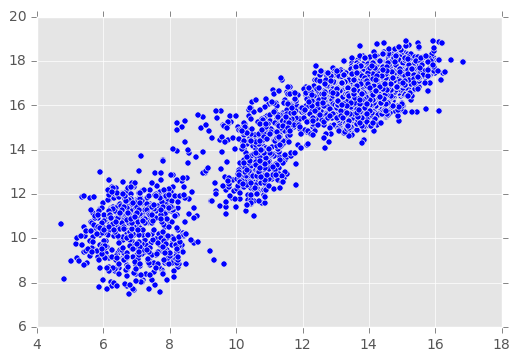

In [166]:
print([f for f in features_eq.columns.values.tolist() if "338" in str(f)])
print([f for f in features_eq.columns.values.tolist() if "333" in str(f)])
names = [f for f in features_eq.columns.values.tolist() if "336" in str(f)]
print(list(names))

plt.scatter(features_eq["CYS159 to TYR336"], features_eq["ARG165_CA to TYR336_CA"]) # features_eq["PHE338 to PHE84"])
plt.show()

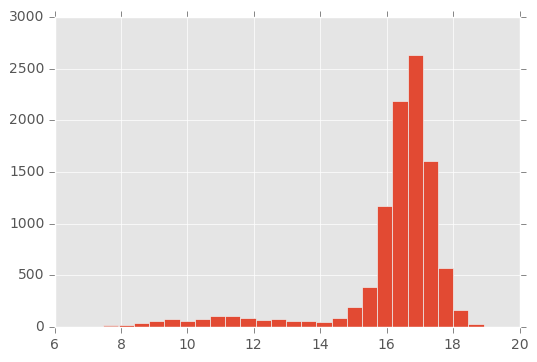

In [164]:
plt.clf()
plt.hist(features_eq["ARG165_CA to TYR336_CA"], bins=25)
plt.show()

In [145]:
ref_features[["PHE338 to PHE84", "LEU339_CA to TYR336_CA"]]

,PHE338 to PHE84,LEU339_CA to TYR336_CA
0,12.547302,5.504129
1,6.497386,5.965643


[LEU121 to TYR128,
 LYS303_CA to ILE301_CA,
 ALA68 to TYR128,
 VAL236_CA to LEU231_CA,
 VAL282_CA to THR279_CA,
 ILE107_CA to MET281_CA,
 VAL89_CA to VAL334_CA,
 VAL286 to TYR336,
 ILE278_CA to LEU283_CA,
 VAL78_CA to TYR326_CA,
 LEU88 to PHE338,
 LYS233_CA to VAL300_CA,
 PHE320_CA to ILE71_CA,
 LEU335_CA to LEU339_CA,
 ARG179 to ALA175,
 THR312_CA to THR315_CA,
 LEU339_CA to LEU283_CA,
 CYS217_CA to THR208_CA,
 THR70 to VAL66,
 LEU339_CA to ARG280_CA,
 LYS233 to VAL300,
 VAL282_CA to MET161_CA,
 MET281_CA to MET161_CA,
 LEU335_CA to PHE338_CA,
 LEU339_CA to ARG277_CA,
 THR67_CA to VAL316_CA,
 ASN150 to PHE289,
 GLY136_CA to TRP133_CA,
 LYS174_CA to ASP177_CA,
 ASN230 to ALA304,
 THR279_CA to MET281_CA,
 ILE322_CA to VAL78_CA,
 ARG165_CA to MET281_CA,
 HIS171_CA to LEU176_CA,
 VAL285_CA to ARG280_CA,
 VAL285 to TYR336,
 GLU341_CA to ARG280_CA,
 ILE301_CA to PHE237_CA,
 CYS79 to TYR326,
 ALA175_CA to ILE167_CA,
 TRP293_CA to VAL288_CA,
 LYS174_CA to HIS171_CA,
 LEU335_CA to MET161_CA,
 

In [132]:
from jointplot_d3 import *
custom_names = ["ARG165_CA to TYR336_CA", "tm6_tm3_packing", "MET281_CA to MET161_CA", "mOR tIC.5", "mOR tIC.8"]
jointplots(features_eq[custom_names].values, analysis_dir, titles = custom_names, main = "mOR MSM", refcoords = ref_features[custom_names].values, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=5., custom_lims=None, n_levels=15, worker_pool=None, parallel=True)

Making delta G plots.
Done plotting columns
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDEComputed 2D KDEmin_density=0.0min_density=0.0



min_density=0.0min_density=0.0Computed Density. Now plotting.
Computed Density. Now plotting.


(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.
Computed Density. Now plotting.


(0.0, 5.0)(0.0, 5.0)[[ 16.21269989   9.15980816]
 [ 12.04389954  13.01761985]][[  9.15980816  10.684412  ]
 [ 13.01761985  13.34047222]]



[[ 10.684412    -1.60038357]
 [ 13.34047222  -0.03905146]][[-1.60038357  1.26288895]
 [-0.03905146 -0.17648318]](2, 9943)(2, 9943)



(2, 9943)Computed 2D KDE
Computed 2D KDE

Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE


Computed Density. Now plotting.(0.0, 5.0)(0.0, 5.0)


(0.0, 5.0)[[ 16.21269989  10.684412  ]
 [ 12.04389954  13.34047222]][[  9.15980816  -1.60038357]
 [ 13.01761985  -0.03905146]]


[[ 10.684412     1.26288895]
 [ 13.34047222  -0.17648318]](

In [127]:
custom_names = ["mOR tIC.2", "mOR tIC.8"]
ref_features[custom_names]

,mOR tIC.2,mOR tIC.8
0,1.041178,1.262889
1,-0.515674,-0.176483


In [55]:
len(bu72_feature_dfs)

512

In [ ]:
#pm = compute_pearson_matrix(features_eq["tm6_tm3_packing"].values.reshape((-1,1)), features_eq.values).reshape((-1,1))
titles_i = ["tm6_tm3_packing"] + pp_tica_eq.columns.values.tolist() + list(set(pp_features_eq.columns.values.tolist()))
titles_j = list(set(bu72_features_eq.columns.values.tolist())) + bu72_tica_eq.columns.values.tolist()
pm = compute_pearson_matrix(features_eq[titles_i].values, features_eq[titles_j].values)
pmdf = pd.DataFrame(pm, index=titles_i, columns=titles_j)

In [ ]:
pmdf.loc["tm6_tm3_packing"].sort(inplace=False)

In [ ]:
try:
    plt.rcParams['xtick.labelsize'] = 6.
    plt.rcParams['ytick.labelsize'] = 8.
    g = sns.clustermap(pmdf, figsize=(10,10))
    plt.show()
except:
    pass

In [ ]:
plt.hexbin(features_eq["Lig900-N1 to Tyr326"], features_eq["tm6_tm3_packing"])

In [ ]:
pmdf.loc[[str(f) for f in bu72_features_eq.columns.values.tolist()]].abs().sort("correlation", ascending=False,inplace=False).iloc[:50].plot(kind='barh')

In [ ]:
import seaborn as sns
from scipy.stats import kendalltau
def hexbin(x, y, color, gridsize=25, n_colors=10, **kwargs):
    cmap = sns.light_palette(color, n_colors=n_colors, as_cmap=True)
    #cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=gridsize, cmap=cmap, **kwargs)
    
g = sns.PairGrid(features_eq[["tm6_tm3_packing", "rmsd_npxxy_inactive", "mOR tIC.4", "mOR tIC.6", "(MET281_CA, MET161_CA)", "(Lig900-C19, Gln124)", "(Lig900-C16, Val300)", "(Lig900-C8, Met151)", "(Lig900-N1, Tyr326)"]])# "(GLY82, TYR326)", "(TYR326, ASP147)", "BU72 tIC.3", "(Lig900-N1, Tyr326)", "(Lig900-C4, Tyr326)", "(Lig900-C20, Gln124)", "(Lig900-C6, Trp293)"]])
g.map_diag(plt.hist, bins=100)
#g.map_upper(sns.kdeplot, cmap="Blues_d", n_levels=10, shade=True, shade_lowest=False)
g.map_upper(plt.scatter, s=0.1, color="purple")
g.map_lower(plt.scatter, s=0.1, color="purple")

In [133]:
def custom_lim_finder(values):
    mins = np.min(values, axis=0)
    maxs = np.max(values, axis=0)
    stds = np.std(values, axis=0)
    custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]
    return custom_lims

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
#titles_i = ["tm6_tm3_packing", "mOR tIC.2"] + [str(f) for f in bu72_pp_tIC_features[1]][:5] + ["BU72 tIC.3"] + [str(f) for f in all_tIC_features[2]][:5]
titles_i = ["tm6_tm3_packing"] + ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)] + ["BU72 tIC.%d" %i for i in range(1,n_components+1)]
features_eq_vals = features_eq[titles_i].values
mins = np.min(features_eq_vals, axis=0)
maxs = np.max(features_eq_vals, axis=0)
stds = np.std(features_eq_vals, axis=0)
custom_lims = [[mins[i] - 0.5*stds[i], maxs[i] + 0.5*stds[i]] for i in range(0,len(mins))]
jointplots(features_eq_vals, analysis_dir, titles = titles_i, main = "mOR MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=5., custom_lims=custom_lims, n_levels=15, worker_pool=None, parallel=True)

In [ ]:
from jointplot_d3 import *
titles_i = ["tm6_tm3_packing", "mOR tIC.2"] + [str(f) for f in bu72_pp_tIC_features[1]] + ["mOR tIC.3"] + [str(f) for f in all_tIC_features[2]]
tica_resampled = np.vstack([verboseload(bu72_pnas_resampled_file)[::1,], verboseload(apo_pnas_resampled_file)[::1,]])
mins = np.min(tica_resampled, axis=0)
maxs = np.max(tica_resampled, axis=0)
stds = np.std(tica_resampled, axis=0)
custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]
jointplots(features_eq[titles_i], analysis_dir, titles = titles_i, main = "mOR MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=5., custom_lims=custom_lims, n_levels=15)

In [ ]:
all_tIC_features[0]

In [ ]:
"""
['bu72_reimaged_rep_100.h5', 'bu72_reimaged_rep_119.h5', 'bu72_reimaged_rep_179.h5', 'bu72_reimaged_rep_184.h5', 'bu72_reimaged_rep_186.h5', 'bu72_reimaged_rep_24.h5', 'bu72_reimaged_rep_255.h5', 'bu72_reimaged_rep_27.h5', 'bu72_reimaged_rep_56.h5', 'bu72_reimaged_rep_58.h5', 'bu72_reimaged_rep_59.h5', 'bu72_reimaged_rep_63.h5', 'bu72_reimaged_rep_64.h5', 'bu72_reimaged_rep_83.h5', 'bu72_rep_139.h5', 'bu72_rep_84.h5']"""
bu72_traj_names = [os.path.basename(t) for t in trajs if "bu72" in t]
traj_idx = bu72_traj_names.index('bu72_rep_139.h5')
f = all_traj_features[traj_idx][["tm6_tm3_packing", "(Lig900-C20, Gln124)", "(Lig900-C3, Trp293)"]]
#f = protein_ligand_msm_featurized[f.columns.values]
pd.rolling_mean(f[f.columns.values[0]], window=50).plot()

In [ ]:
pd.rolling_mean(f[f.columns.values[1]], window=50).plot()

In [ ]:
pmdf.index.values

In [ ]:
bu72_pp_pnas.T[1,:].shape

In [ ]:
from pandas.tools.plotting import scatter_matrix
#df = pd.concat([pp_features_eq, bu72_features_eq], axis=1)[["(MET281_CA, MET161_CA)", "(Lig900-N1, Tyr326)"] + [str(f) for f in bu72_pp_tIC_features[2][:2] +  all_tIC_features[2][:2]]]
df = features_eq[all_features[0]]
sm = scatter_matrix(df.iloc[::100], figsize=(6, 6), diagonal='kde')
[s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
plt.show()

In [ ]:
import seaborn as sns



g = sns.PairGrid(features_eq[all_features[0]])
g.map_upper(sns.jointplot, kind="hex", stat_func=kendalltau, color="#4CB391")
#cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
#g.map_lower(sns.kdeplot, cmap="Blues_d", n_levels=5, shade=True, shade_lowest=False)
#g.map_diag(sns.kdeplot)
#g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6)

In [59]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
keep_steps = 20000
subsample = 100
ligand_msm_featurized_traj = resample_features_by_msm_trajectory(ligand_top_features, msm_traj_index_pairs[0:keep_steps])
protein_msm_featurized_traj = resample_features_by_msm_trajectory(protein_top_features, msm_traj_index_pairs[0:keep_steps])
protein_msm_tica_traj = resample_features_by_msm_trajectory(bu72_tica_dfs, msm_traj_index_pairs[0:keep_steps])
protein_msm_pnas_traj = resample_features_by_msm_trajectory(bu72_pnas_dfs, msm_traj_index_pairs[0:keep_steps])
bu72_msm_tica_traj = resample_features_by_msm_trajectory(tica_dfs, msm_traj_index_pairs[0:keep_steps])


protein_ligand_msm_featurized = pd.concat([ligand_msm_featurized_traj*10., protein_msm_featurized_traj*10., protein_msm_tica_traj, protein_msm_pnas_traj, bu72_msm_tica_traj], axis=1)
plmf = protein_ligand_msm_featurized.iloc[::10]

In [60]:
lig_features = list(set([str(g) for l in all_tIC_features for g in l]))
prot_features = list(set([str(g) for l in bu72_pp_tIC_features for g in l]))
f0 = pd.concat([f*10. for f in ligand_top_features], axis=0)
f1 = pd.concat([f*10. for f in protein_top_features], axis=0)
f2 = pd.concat([f for f in bu72_tica_dfs])
f3 = pd.concat([f for f in bu72_pnas_dfs])
prot_lig_features = pd.concat([f0,f1,f2,f3],axis=1)
all_traj_features = [pd.concat([ligand_top_features[i]*10., protein_top_features[i]*10., bu72_tica_dfs[i], bu72_pnas_dfs[i]], axis=1) for i in range(0, len(bu72_tica_dfs))]
pm = compute_pearson_matrix(f0[lig_features].values, f1[prot_features].values)
#pmdf = pd.DataFrame(pm, columns=prot_features, index=lig_features)


In [61]:
all_traj_features_np = [f.values for f in all_traj_features]
cluster_features_averages = calculate_cluster_averages_per_feature(bu72_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features[0].columns)

tpt_paths_features = []
for tpt_path in inv_tpt_paths:
    tpt_paths_features.append(cluster_features_averages.iloc[tpt_path])

In [66]:
intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["GLY82 to TYR326"] < 4.)].index.values
msm_intermediate_actives = bu72_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(bu72_pp_msm.populations_[msm_intermediate_actives])
print(bu72_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])

[  2.34170769e-05   4.56647403e-05   4.70086415e-05   7.92558148e-05
   8.47803761e-05   9.76371770e-05   9.86769725e-05   1.03679968e-04
   1.21575807e-04   1.26594245e-04   1.73174559e-04   1.88981050e-04
   2.09702601e-04   2.20444984e-04   2.30029661e-04   2.35039702e-04
   2.57502822e-04   2.64440667e-04   2.70504834e-04   2.73914058e-04
   2.76069935e-04   2.81507838e-04   2.95764830e-04   2.96213079e-04
   3.00629046e-04   3.21601556e-04   3.24037711e-04   3.42587239e-04
   3.78834687e-04   3.89027721e-04   4.41513653e-04   4.57354794e-04
   4.68643330e-04   4.82212183e-04   5.35643393e-04   5.83099148e-04
   6.47679987e-04   6.55065684e-04   6.88967543e-04   7.07098885e-04
   7.43457316e-04   7.44661776e-04   8.88546056e-04   1.00712901e-03
   1.02411416e-03   1.03928142e-03   1.15852768e-03]
[  6  20  38  69  95  98 103 169 173 184 198 262 269 270 290 297 305 313
 315 316 326 362 386 469 477 513 521 554 636 642 656 672 685 697 764 777
 788 816 828 840 849 857 859 879 883 888 9

In [70]:
tpt_paths_features[6]["Lig900-N1 to Tyr326"]

62     4.997254
901    5.185735
239    5.222610
80     5.170358
462    6.253157
706    5.616885
75     7.118384
Name: Lig900-N1 to Tyr326, dtype: float64

In [ ]:
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(PHE156, SER196)"] > 9.5) & (cluster_features_averages["(PHE156, SER196)"] < 10.5)].index)
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(PHE156, SER196)"] > 6.) & (cluster_features_averages["(PHE156, SER196)"] < 7.)].index)

In [ ]:
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 11.) & (cluster_features_averages["(ASP114, TYR336)"] > 8.)& (cluster_features_averages["(Lig900-C19, Ile322)"] > 5.)].index)

In [ ]:
plt.hist(features_eq["Lig900-N1 to Tyr326"], bins=200)
plt.show()

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["mOR tIC.6"] > 4.)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 10.) & (cluster_features_averages["rmsd_npxxy_inactive"]<0.3)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 13.) & (cluster_features_averages["rmsd_npxxy_inactive"]<0.3)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(VAL89_CA, TYR336_CA)"] >11.5)].index

In [ ]:
g = sns.PairGrid(prot_lig_features[["tm6_tm3_packing", "tIC.3", "(Lig900-C20, Gln124)", "(Lig900-C3, Trp293)"]])
g.map_diag(plt.hist, bins=100)
#g.map_upper(sns.kdeplot, cmap="Blues_d", n_levels=10, shade=True, shade_lowest=False)
g.map_upper(hexbin, color="purple", n_colors=30, gridsize=30)
g.map_lower(plt.scatter, s=.1)

In [ ]:
protein_top_features[0].iloc[::3]

In [ ]:
import seaborn as sns

In [ ]:
pmdf

In [ ]:
try:
    plt.rcParams['xtick.labelsize'] = 6.
    plt.rcParams['ytick.labelsize'] = 8.
    g = sns.clustermap(pmdf, figsize=(10,10))
    plt.show()
except:
    pass

In [ ]:
prot_lig_features.plot(kind='scatter', x="(MET281_CA, MET161_CA)", y= "(Lig900-C10, Val236)")

In [ ]:
plmf.columns.values

In [69]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
if not os.path.exists("%s/rfr_r2_scores.h5" %analysis_dir):
    r2_scores, importances = compute_rf_matrix(tica_resampled, bu72_pp_tica, n_trees=500, n_folds=10)
    verbosedump(r2_scores, "%s/rfr_r2_scores.h5" %analysis_dir)
    verbosedump(importances, "%s/rfr_importances.h5" %analysis_dir)
else:
    r2_scores = verboseload("%s/rfr_r2_scores.h5" %analysis_dir)
    importances = verboseload("%s/rfr_importances.h5" %analysis_dir)

Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/analysis_n_clusters1000_random/rfr_r2_scores.h5"... (<type 'list'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-normalized/analysis_n_clusters1000_random/rfr_importances.h5"... (<type 'numpy.ndarray'>)


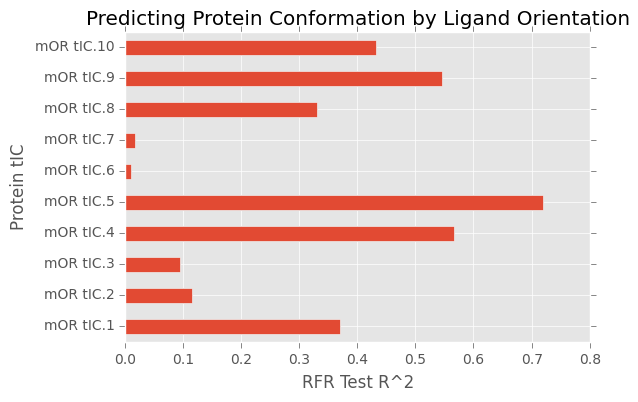

In [93]:
r2_scores_df = pd.Series(r2_scores, index=["mOR tIC.%d" %i for i in range(1, len(r2_scores)+1)])
title = "Predicting Protein Conformation by Ligand Orientation"
r2_scores_df.plot(kind='barh', title=title)
plt.xlabel("RFR Test R^2")
plt.ylabel("Protein tIC")
plt.savefig("%s/%s.pdf" %(analysis_dir, title))
plt.show()

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
#if not os.path.exists("%s/rfr_r2_scores.h5" %analysis_dir):
pd.concat([pp_features_eq, bu72_features_eq, pp_tica_eq, bu72_tica_eq, bu72_pnas_eq], axis=1)
#y = pd.concat([pp_tica_eq, bu72_pnas_eq["tm6_tm3_packing", "rmsd_npxxy_active"]], axis=1)

y = pd.concat([pp_features_eq, bu72_pnas_eq, pp_tica_eq],axis=1)
x = bu72_all_features_eq

#if not os.path.exists("%s/all_features_rfr_r2_scores.h5" %analysis_dir):
r2_scores, importances = compute_rf_matrix(x.values, y.values, n_trees=500, n_folds=10)
verbosedump(r2_scores, "%s/all_features_rfr_r2_scores.h5" %analysis_dir)
verbosedump(importances, "%s/all_features_rfr_importances.h5" %analysis_dir)
#else:
#    r2_scores = verboseload("%s/all_features_rfr_r2_scores.h5" %analysis_dir)
#    importances = verboseload("%s/all_features_rfr_importances.h5" %analysis_dir)

In [103]:
r2_scores_df = pd.Series(r2_scores, index=y.columns)
title = "Predicting Protein Conformation by Ligand Orientation"
r2_scores_df.plot(kind='barh', title=title)
plt.xlabel("RFR Test R^2")
plt.ylabel("Protein Feature")
plt.savefig("%s/all_features_%s.pdf" %(analysis_dir, title))

In [104]:
len(r2_scores)

137

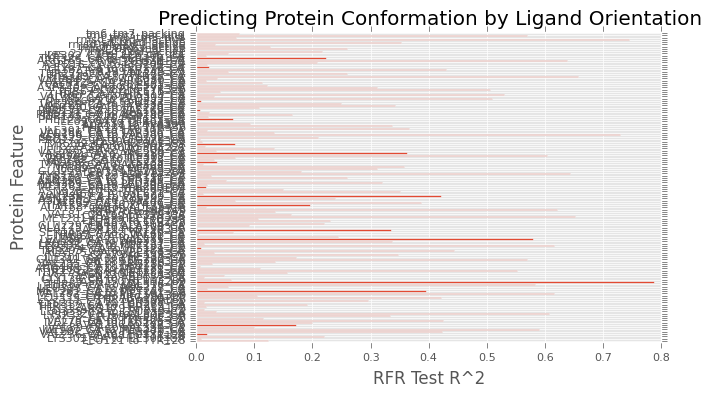

In [105]:
plt.show()

In [125]:
r2_scores_df["tm6_tm3_packing"]

0.56826606261024926

In [134]:
#pearson_matrix = compute_pearson_matrix(x.values, y.values)
#pearson_df = pd.DataFrame(pearson_matrix, columns=y.columns, index=x.columns)
pearson_df["tm6_tm3_packing"].abs().sort(inplace=False)

Lig900-C15 to Trp318    0.001749
Lig900-C27 to Asn127    0.002839
Lig900-C17 to Ile322    0.006941
Lig900-C24 to Trp318    0.011138
Lig900-C13 to Ile296    0.027216
Lig900-C21 to Tyr326    0.029765
Lig900-C5 to Asp147     0.029853
Lig900-C25 to Trp318    0.030498
Lig900-C3 to Asn150     0.033250
Lig900-C4 to Gly325     0.033278
Lig900-C14 to Ile322    0.036184
Lig900-C6 to Ile296     0.036977
Lig900-N2 to Asp147     0.041980
Lig900-C4 to Asp147     0.046370
Lig900-C16 to Ile322    0.047420
Lig900-C27 to Val143    0.050139
Lig900-C28 to Gln124    0.055334
Lig900-C15 to Ile296    0.057051
Lig900-C18 to Asp147    0.057583
Lig900-O1 to His297     0.060241
Lig900-C13 to Asp147    0.061015
Lig900-C16 to Cys321    0.061146
Lig900-C20 to Tyr326    0.064285
Lig900-C28 to Val143    0.068884
Lig900-C23 to Asp147    0.069954
Lig900-C7 to Trp293     0.075699
Lig900-C19 to Tyr326    0.080285
Lig900-C19 to Asp147    0.082131
Lig900-C26 to Gln124    0.082826
Lig900-C21 to Asp147    0.088740
          

In [135]:
importances_df = pd.DataFrame(importances, columns=y.columns, index=x.columns)
importances_df["tm6_tm3_packing"].abs().sort(inplace=False)



Lig900-C26 to Cys217    0.000000
Lig900-C11 to Ile296    0.000000
Lig900-C23 to Asp147    0.000000
Lig900-C5 to Ile296     0.000000
Lig900-C16 to Ile322    0.000000
Lig900-C25 to Cys217    0.000000
Lig900-C4 to Asp147     0.000000
Lig900-C5 to Asp147     0.000000
Lig900-N2 to Asp147     0.000000
Lig900-C26 to Thr218    0.000000
Lig900-C26 to Ile144    0.000000
Lig900-C26 to Gln124    0.000000
Lig900-C27 to Cys217    0.000000
Lig900-C27 to Ile144    0.000000
Lig900-C27 to Gln124    0.000000
Lig900-C27 to Asn127    0.000000
Lig900-C28 to Cys217    0.000000
Lig900-C28 to Ile144    0.000000
Lig900-C1 to Asp147     0.000000
Lig900-C2 to Met151     0.000000
Lig900-C2 to Asp147     0.000000
Lig900-N1 to Tyr326     0.000000
Lig900-N1 to Met151     0.000000
Lig900-N1 to Asp147     0.000000
Lig900-O2 to Ile322     0.000000
Lig900-C3 to Asp147     0.000000
Lig900-C16 to Ile296    0.000000
Lig900-C17 to Ile322    0.000000
Lig900-C14 to Ile322    0.000000
Lig900-O1 to Val300     0.000000
          

[  5  12  21  25  26  31  36  42  45  55  58  74  82  91 107 109 111 117
 124 133 135]
[1, 130, 91, 131, 5, 70, 33, 104, 73, 106, 11, 12, 110, 99, 136, 19, 88, 89, 27, 95]
21


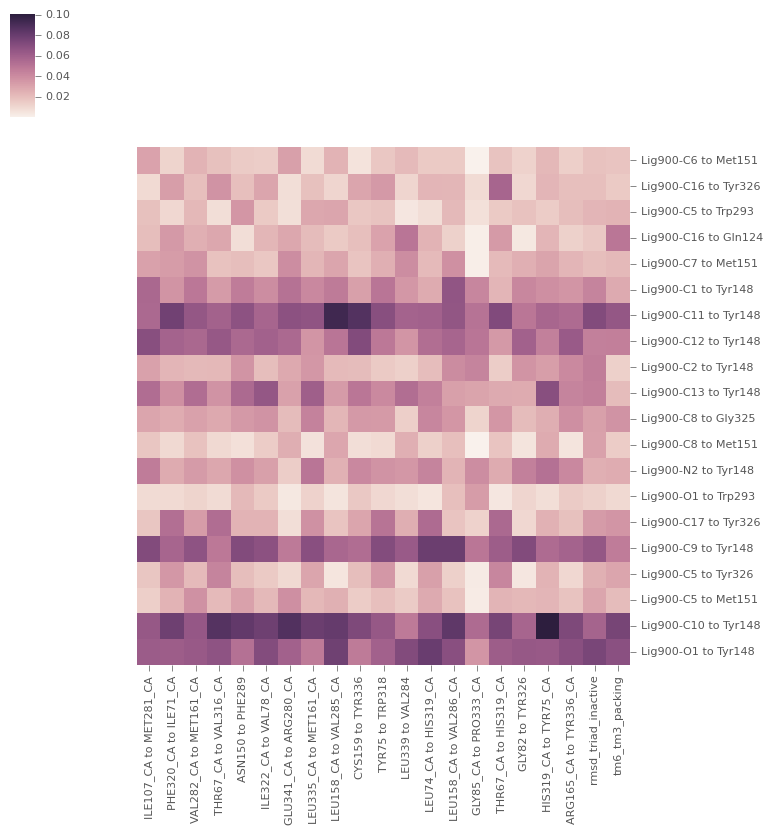

'\n\nplot_clustermap(importances_df, save_file="%s/feature_importances.pdf" %(save_dir, experiment_name), method=\'average\', z_score=None)\n\n\n\nfig = plt.figure()\nax = fig.add_subplot(111)\nheatmap = ax.pcolor(np.abs(pearson_matrix), cmap=plt.cm.Blues)\n\n# put the major ticks at the middle of each cell\nax.set_xticks(np.arange(pearson_matrix.shape[0])+0.5, minor=False)\nax.set_yticks(np.arange(pearson_matrix.shape[1])+0.5, minor=False)\n\n# want a more natural, table-like display\n#ax.invert_yaxis()\n#ax.xaxis.tick_top()\n\nax.set_xticklabels(row_labels, minor=False, rotation=270)\nax.set_yticklabels(column_labels, minor=False)\nfig.subplots_adjust(bottom=0.2)\n\nfig.savefig("%s/bu72_vs_pp_pearson_heatmap.svg" % analysis_dir, format=\'svg\', dpi=1200)\nplot_file = "%s/bu72_vs_pp_pearson_heatmap.pdf" % analysis_dir\npp = PdfPages(plot_file)\n\npp.savefig(fig)\n\npp.close()  \nplt.show()\n'

In [141]:
#import matplotlib
#matplotlib.style.use('ggplot')
#from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from plots import *
sc = StandardScaler()

#importances_scaled = pearson_matrix.T
#importances_scaled = sc.fit_transform(importances)
importances_scaled = copy.deepcopy(importances)
#for j in range(0, importances_scaled.shape[1]):
#    importances_scaled[:,j] *= r2_scores[j]

responses_to_keep = np.where(np.array(r2_scores) > 0.5)[0]
importances_scaled = importances_scaled[:,responses_to_keep]
predictors_to_keep = list(set(np.where(importances_scaled > 0.03)[0].tolist()))
print(responses_to_keep)
print(predictors_to_keep)
importances_scaled = importances_scaled[predictors_to_keep,:]
print(len(responses_to_keep))

#row_labels = ["BU72 tIC.%d" %i for i in range(1, n_components+1)]
#column_labels = ["mOR tIC.%d" %i for i in range(1, pp_n_components+1)]
row_labels = x.columns.values[predictors_to_keep]
column_labels = y.columns.values[responses_to_keep]

importance_df = pd.DataFrame(importances_scaled, columns=column_labels, index=row_labels)

plot_clustermap(importance_df, save_file="%s/all_features_rfr_feature_importances.pdf" %(analysis_dir), method='average', row_cluster=False, col_cluster=False, z_score=None, xtick_labelsize=8, ytick_labelsize=8)
plt.show()

"""

plot_clustermap(importances_df, save_file="%s/feature_importances.pdf" %(save_dir, experiment_name), method='average', z_score=None)



fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = ax.pcolor(np.abs(pearson_matrix), cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(pearson_matrix.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(pearson_matrix.shape[1])+0.5, minor=False)

# want a more natural, table-like display
#ax.invert_yaxis()
#ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False, rotation=270)
ax.set_yticklabels(column_labels, minor=False)
fig.subplots_adjust(bottom=0.2)

fig.savefig("%s/bu72_vs_pp_pearson_heatmap.svg" % analysis_dir, format='svg', dpi=1200)
plot_file = "%s/bu72_vs_pp_pearson_heatmap.pdf" % analysis_dir
pp = PdfPages(plot_file)

pp.savefig(fig)

pp.close()  
plt.show()
"""

In [132]:
from jointplot_d3 import *
titles_j = [f for f in features_eq.columns.values if "Lig" in f and "Tyr326" in f]
print(titles_j)
jointplots(features_eq[titles_j].values, analysis_dir, titles=titles_j,
                           main = "mOR MSM", refcoords=None, refcoords_j=None, axes=None,
                               data_j=features_eq[["tm6_tm3_packing"]].values, titles_j=["tm6_tm3_packing"], reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    

['Lig900-N1 to Tyr326', 'Lig900-C3 to Tyr326', 'Lig900-C4 to Tyr326', 'Lig900-C5 to Tyr326', 'Lig900-C16 to Tyr326', 'Lig900-C17 to Tyr326', 'Lig900-C18 to Tyr326', 'Lig900-C19 to Tyr326', 'Lig900-C20 to Tyr326', 'Lig900-C21 to Tyr326']
Making delta G plots.
Done plotting columns
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 1)
(9943, 1)
(9943, 1)
(9943, 1)
(9943, 1)
(9943, 1)
(2, 9943)(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)

Computed 2D KDEComputed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE

min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





i=6i=9i=8
i=7

j=0

j=0
j=0
(9943, 

r2_scores

In [95]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=3, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    bu72_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(bu72_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            #if prot_idx != 9: continue
            print(lig_order)
            for l, lig_idx in enumerate(lig_order):
                if l == n_lig_tICs:
                    break
            
                features = []

                print("mOR tIC.%d" %(k+1))
                prot_features = ["mOR tIC.%d" %(prot_idx+1)]
                if custom_features is not None:
                    prot_features += custom_features[0]
                lig_features = ["BU72 tIC.%d" %(lig_idx+1)]
                all_prot_features = [str(f) for f in top_features_per_tIC_i[prot_idx]]
                all_lig_features = [str(f) for f in top_features_per_tIC_j[lig_idx]]
                pearson_matrix = compute_pearson_matrix(plmf[all_prot_features].values, plmf[all_lig_features].values)
                pearson_shape = pearson_matrix.shape
                inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(pearson_matrix).ravel()), pearson_shape))[0]
                prot_inds = []
                lig_inds = []

                for j, ind in enumerate([idx[0] for idx in inds]):
                    if len(prot_inds) == max_features: break
                    if ind in prot_inds: continue
                    prot_features.append(str(top_features_per_tIC_i[prot_idx][ind]))
                    prot_inds.append(ind)

                if custom_features is not None:
                    features += custom_features[0]

                for j, ind in enumerate([idx[1] for idx in inds]):
                    if len(lig_inds) == max_features: break
                    if ind in lig_inds: continue
                    lig_features.append(str(top_features_per_tIC_j[lig_idx][ind]))
                    lig_inds.append(ind)

                if make_jointplots:
                    print("Creating joint deltaG plots.")
                    data_i = features_eq[prot_features+all_prot_features].values
                    print(data_i.shape)
                    data_j = features_eq[lig_features+all_lig_features].values
                    print(data_j.shape)
                    tic_save_dir = "%s/mOR_tIC%d_vs_BU72_tIC%d" %(save_dir, prot_idx+1, lig_idx+1)
                    if not os.path.exists(tic_save_dir):
                        os.makedirs(tic_save_dir)
                    #else:
                    #    continue
                    
                    
                    if ref_df is not None:
                        refcoords = ref_df[prot_features+all_prot_features].values
                        print(refcoords.shape)
                        refcoords_j = ref_df[lig_features+all_lig_features].values
                        print(refcoords_j.shape)
                    else:
                        refcoords = None
                        refcoords_j = None

                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                               data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                               main = "mOR MSM", refcoords=refcoords, axes=None,
                               data_j=None, titles_j=None, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_j, tic_save_dir, titles=lig_features+all_lig_features,
                           main = "mOR MSM", refcoords=refcoords_j, refcoords_j=refcoords, axes=None,
                               data_j=data_i, titles_j=prot_features+all_prot_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)

                features += (prot_features + lig_features)
    
                #plot_df_rolling(plmf[features].iloc[::subsample], "%s/key_measurements_tIC%d.pdf" %(save_dir, prot_idx+1), True, smoothing=smoothing, include_original=False, subplots=True, min_periods=None)
                #plt.show()  
                all_features.append(features)
    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      bu72_pp_tIC_features, all_tIC_features, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=3, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=jointplots_refcoords_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "BU72 tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "BU72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), bu72_pp_tIC_features, all_tIC_features, n_combs=2)

[2 4 6 7 0 3 9 1 8 5]
mOR tIC.1
Creating joint deltaG plots.
(9943, 18)
(9943, 6)
(2, 18)
(2, 6)
Making delta G plots.
Done plotting columns
Making delta G plots.
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 6)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





[[-1.60038357 -0.37161728]
 [-0.03905146 -0.48873874]][[  9.15980816  -0.37161728]
 [ 13.01761985  -0.48873874]][[ 0.64148617 -0.37161728]
 [ 0.         

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(9943, 18)
(9943, 18)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 6)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





[[-1.60038357  3.74226046]
 [-0.03905146  3.85107708]][[  9.15980816   3.74226046]
 [ 13.01761985   3.85107708]][[ 0.64148617  3.74226046]
 [ 0.          3.85107708]][[ 0.          3.74226046]
 [ 0.64148796  3.85107708]][[ 9.28451443  3.74226046]
 [ 9.20263004  3.85107708]][[ 6.55276775  3.74226046]
 [ 7.51085329  3.85107708]]





i=0i=1i=2i=3i=4i=5





j=4
j=4
j=4
j=4
j=4
j=4
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 6)
(9943,

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se



[[-1.60038357  6.55276775]
 [-0.03905146  7.51085329]][[  9.15980816   3.83722496]
 [ 13.01761985   3.35832787]][[ 0.64148617  7.21754074]
 [ 0.          5.87020302]][[  0.          11.49536228]
 [  0.64148796   6.1882062 ]][[ 9.28451443  7.01753807]
 [ 9.20263004  6.4855423 ]][[ 6.55276775  8.93306351]
 [ 7.51085329  6.18403959]]





(2, 9943)(2, 9943)(2, 9943)(2, 9943)(2, 9943)(2, 9943)





Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





[[-1.60038357  3.83722496]
 [-0.03905146  3.35832787]][[  9.15980816   7.21754074]
 [ 13.01761985   5.87020302]][[  0.64148617  11.49536228]
 [  0.           6.1882062 ]][[ 0.          7.01753807]
 [ 0.64148796  6.4855423 ]][[ 9.28451443  8.93306

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

j=3
(9943, 6)
(9943, 18)
(9943, 18)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 18)
(2, 9943)
(2, 9943)
(9943, 18)
(9943, 18)
(9943, 18)
(2, 9943)
Computed 2D KDE
Computed 2D KDE
(2, 9943)
(2, 9943)
(2, 9943)
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.

Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.
(0.0, 5.0)(0.0, 5.0)


(0.0, 5.0)

(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
[[-0.37161728  0.        ]
 [-0.48873874  0.64148796]][[ 6.10984325  0.        ]
 [ 4.68674994  0.64148796]]


[[ 6.10984325  0.        ]
 [ 4.68674994  0.64148796]]

[[ 5.63864613  0.        ]
 [ 8.93667793  0.64148796]][[ 3.74226046  0.        ]
 [ 3.85107708  0.64148796]][[ 8.23964214  0.        ]
 [ 6.61890507  0.64148796]]
i=0i=1


i=5

i=2i=3i=4
j=4
j=4



j=4
(9943, 6)
(9943, 6)
j=4
j=4
j=4
(9943, 6)
(9943, 18)
(9943, 18)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 18)
(2, 9

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(9943, 18)
(9943, 18)
(9943, 9)
(9943, 9)
(9943, 9)
(9943, 9)
(9943, 9)
(9943, 9)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





[[-1.60038357  7.36696768]
 [-0.03905146  5.64674473]][[  9.15980816   7.36696768]
 [ 13.01761985   5.64674473]][[ 0.64148617  7.36696768]
 [ 0.          5.64674473]][[ 0.          7.36696768]
 [ 0.64148796  5.64674473]][[ 7.59589767  7.36696768]
 [ 6.89162016  5.64674473]][[ 6.55276775  7.36696768]
 [ 7.51085329  5.64674473]]





i=0i=1i=2i=3i=4i=5





j=4
j=4
j=4
j=4
j=4
j=4
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 9)
(9943, 9)
(9943, 9)
(9943, 9)
(9943, 9)
(9943,

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(9943, 9)
(9943, 9)
(9943, 9)
(9943, 9)
Computed Density. Now plotting.





(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)

[[-1.60038357  0.        ]
 [-0.03905146  0.64148796]][[  9.15980816   7.59589767]
 [ 13.01761985   6.89162016]][[ 0.64148617  6.55276775]
 [ 0.          7.51085329]][[ 0.          3.83722496]
 [ 0.64148796  3.35832787]][[ 7.59589767  7.21754074]
 [ 6.89162016  5.87020302]][[  6.55276775  11.49536228]
 [  7.51085329   6.1882062 ]]Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(0.0, 5.0)





Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.
(2, 9943)(2, 9943)(2, 9943)(2, 9943)(2, 9943)(2, 9943)



[[ 11.37884331   9.93360329]
 [  8.582757     9.00953674]]





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE




i=14Computed Density. Now plotti

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

[[ 0.78392434  7.59589767]
 [-0.03578326  6.89162016]][[ 7.36683178  7.59589767]
 [ 6.08405638  6.89162016]]





i=3i=2i=4i=5i=0i=1





j=5
j=5
j=5
j=5
j=5
j=5
(9943, 9)
(9943, 9)
(9943, 9)
(9943, 9)
(9943, 9)
(9943, 9)
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





[[ 7.36696768  6.55276775]
 [ 5.64674473  7.51085329]][[ 9.93360329  6.55276775]
 [ 9.00953674  7.51085329]][[ 5.37994671  6.55276775]
 [ 3.94167447  7.51085329]][[ 2.51758337  6.55276775]
 [ 2.65806818  7.51085329]][[ 0.78392434  6.55276775]
 [-0.03578326  7.51085329]][[ 7.36683178  6.55276775]
 

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se


Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE

Computed 2D KDE

i=6Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.j=11





Computed Density. Now plotting.
(9943, 9)
j=11
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)(9943, 18)
(9943, 9)




(0.0, 5.0)
(2, 9943)
(9943, 18)
[[-1.60038357  5.22151518]
 [-0.03905146  4.89633512]][[  9.15980816   5.22151518]
 [ 13.01761985   4.89633512]][[ 0.64148617  5.22151518]
 [ 0.          4.89633512]][[ 0.          5.22151518]
 [ 0.64148796  4.89633512]]
[[ 6.55276775  5.22151518]
 [ 7.51085329  4.89633512]]Computed 2D KDE
(2, 9943)




[[ 3.83722496  5.22151518]
 [ 3.35832787  4.89633512]]
Computed Density. Now plotting.Computed 2D KDE
i=0i=1i=2i=3
i=5
Computed Density. Now plotting.



i=4
(0.0, 5.0)
j=3
j=3
j=3
j=3

j=3

(0.0, 5.0)(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
j=3
(9943, 18)
[[ 11.2376918

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.
Computed Density. Now plotting.i=12(9943, 18)
i=9i=8i=11i=10



Computed 2D KDE


(9943, 12)




(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.(0.0, 5.0)j=7
(2, 9943)
j=7
j=7
j=7
j=7






(9943, 18)
Computed 2D KDE
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
[[-1.60038357  0.        ]
 [-0.03905146  0.64148796]][[  9.15980816   3.83722496]
 [ 13.01761985   3.35832787]][[ 0.64148617  6.55276775]
 [ 0.          7.51085329]][[ 0.          7.21754074]
 [ 0.64148796  5.87020302]](0.0, 5.0)[[  6.55276775  11.49536228]
 [  7.51085329   6.1882062 ]](9943, 12)
Computed Density. Now plotting.(9943, 12)
(9943, 12)
(9943, 12)
(9943, 12)






(2, 9943)

(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)(2, 9943)(2, 9943)(2, 9943)[[  3.83722496  11.49536228]
 [  3.35832787   6.1882062 ]](2, 9943)Computed 2D KDE
(0.0, 5.0)Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D K

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se



(9943, 18)
(9943, 12)
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
(2, 9943)(0.0, 5.0)Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 9943)(2, 9943)(2, 9943)(2, 9943)[[ 7.21754074  7.59589767]
 [ 5.87020302  6.89162016]](2, 9943)
(9943, 18)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)


Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.




Computed 2D KDE
(2, 9943)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
[[ 7.59589767  5.22151518]
 [ 6.89162016  4.89633512]]



Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 9943)Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plo

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed Density. Now plotting.Computed Density. Now plotting.(0.0, 5.0)
[[-1.3115471   9.28451443]
 [-0.42255366  9.20263004]][[ 7.1751833   9.28451443]
 [ 7.06146431  9.20263004]][[ 5.1002841   9.28451443]
 [ 4.68973684  9.20263004]][[ 9.93360329  9.28451443]
 [ 9.00953674  9.20263004]][[ 5.22151518  9.28451443]
 [ 4.89633512  9.20263004]]





(0.0, 5.0)




(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)[[ 3.77688146  9.28451443]
 [ 3.69010115  9.20263004]]
i=0i=5i=3i=4i=2





[[ 5.9295125   2.51758337]
 [ 9.7176075   2.65806818]]




[[ 0.25465436  2.51758337]
 [-0.09941434  2.65806818]][[  9.15980816   2.51758337]
 [ 13.01761985   2.65806818]][[ 0.64148617  2.51758337]
 [ 0.          2.65806818]][[ 0.          2.51758337]
 [ 0.64148796  2.65806818]][[ 8.44507885  2.51758337]
 [ 8.60399818  2.65806818]]i=1
j=13
j=13
j=13
j=13
j=13






i=5(9943, 12)
(9943, 12)
(9943, 12)
(9943, 12)
(9943, 12)
i=0i=1i=2i=3i=4j=13

(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)
(9943, 18)





(99

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed 2D KDE
Computed 2D KDE
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
Computed Density. Now plotting.



j=13
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





i=6
i=7i=8j=4
j=4
(9943, 12)





[[ 0.64148617  8.44507885]
 [ 0.          8.60399818]][[ 0.25465436  0.64148617]
 [-0.09941434  0.        ]][[  9.15980816   0.        ]
 [ 13.01761985   0.64148796]][[ 0.          5.9295125 ]
 [ 0.64148796  9.7176075 ]][[ 8.44507885  5.61469364]
 [ 8.60399818  6.64069271]][[  5.9295125    8.39526081]
 [  9.7176075   10.54314613]]
(0.0, 5.0)

(9943, 12)
(9943, 12)
(9943, 18)
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





j=4

j=4
j=4
(9943, 18)
(9943, 18)
i=11





(2, 9943)(2, 9943)(2, 9943)(2, 9943)(2, 9943)(2, 9943)(9943, 12)
[[ 5.28732347  9.93360329]
 [ 5.01446486  9.00953674]](9943, 12)
(9943, 12)
(2, 9943)
(2, 9943)
j=14
[[  8.39526081   9.93360329

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se




[[  0.78392434   9.15980816]
 [ -0.03578326  13.01761985]][[  2.51758337   9.15980816]
 [  2.65806818  13.01761985]][[  9.93360329   9.15980816]
 [  9.00953674  13.01761985]][[  7.36696768   9.15980816]
 [  5.64674473  13.01761985]]j=12
(9943, 17)
j=12
j=12
(9943, 18)
(9943, 12)

(0.0, 5.0)(0.0, 5.0)

(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.
Computed Density. Now plotting.




(9943, 12)
(9943, 9)
(9943, 12)
(9943, 12)
(2, 9943)
(9943, 18)
(0.0, 5.0)

i=5i=4



(0.0, 5.0)(0.0, 5.0)i=0i=1i=2i=3(9943, 18)
i=15
(9943, 18)
(9943, 18)
Computed 2D KDE
(2, 9943)

[[ 10.95594311   2.51758337]
 [ 16.1169796    2.65806818]][[ 4.87550068  2.51758337]
 [ 5.00048065  2.65806818]]

[[ 8.49121094  2.51758337]
 [ 8.66649532  2.65806818]][[ 0.64148617  5.13342762]
 [ 0.          5.17386532]][[ 0.25465436  4.87550068]
 [-0.09941434  5.00048065]][[  9.15980816   8.49121094]
 [ 13.01761985   8.66649532]]





(2, 9943)
j=6
(2, 9943)
(2, 9943)
Computed Density. Now plottin

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se


(9943, 9)
Computed Density. Now plotting.Computed Density. Now plotting.(0.0, 5.0)
Computed 2D KDE
(0.0, 5.0)
(9943, 17)
(9943, 17)


Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(9943, 17)
(9943, 17)
(9943, 17)
(9943, 17)





Computed 2D KDE
(2, 9943)



(0.0, 5.0)Computed Density. Now plotting.
[[ 4.87550068  7.36683178]
 [ 5.00048065  6.08405638]](2, 9943)
(2, 9943)
[[ 8.49121094  7.36683178]
 [ 8.66649532  6.08405638]][[ 5.9295125   1.08422264]
 [ 9.7176075   0.83353966]]min_density=0.0min_density=0.0min_density=0.0Computed Density. Now plotting.(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
[[ 0.25465436  1.08422264]
 [-0.09941434  0.83353966]][[  9.15980816   1.08422264]
 [ 13.01761985   0.83353966]][[ 0.64148617  1.08422264]
 [ 0.          0.83353966]][[ 0.          1.08422264]
 [ 0.64148796  0.83353966]][[ 8.44507885  1.08422264]
 [ 8.60399818  0.83353966]]Computed Density. Now plotting.Computed 2D KDE
(0.0, 5.0)(0.0, 5.0)[[  7.43649864  11.1704874 ]
 [  7.9150495

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(9943, 17)
(9943, 17)
(9943, 17)
(9943, 17)
(9943, 17)
(9943, 17)
j=15

j=15
j=15

j=15






(9943, 6)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 9)
j=15
(9943, 9)
(9943, 9)
j=15
(9943, 9)
[[ 0.25465436  0.64148617]
 [-0.09941434  0.        ]][[  9.15980816   0.        ]
 [ 13.01761985   0.64148796]][[ 0.64148617  8.44507885]
 [ 0.          8.60399818]][[ 0.          5.9295125 ]
 [ 0.64148796  9.7176075 ]][[ 8.44507885  5.61469364]
 [ 8.60399818  6.64069271]][[  5.9295125    8.39526081]
 [  9.7176075   10.54314613]](2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(9943, 17)
(9943, 9)
(9943, 17)
(9943, 17)
(9943, 9)
(9943, 17)






Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
i=3(9943, 17)
i=1
i=5
(9943, 17)
i=0
(2, 9943)(2, 9943)(2, 9943)(2, 9943)(2, 9943)(2, 9943)Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now pl

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(9943, 17)


i=7i=6

(2, 9943)(9943, 17)
(9943, 17)
(9943, 17)
(2, 9943)
(2, 9943)
(2, 9943)(2, 9943)(2, 9943)
(9943, 6)
[[ 11.23769188   8.39526081]
 [  7.81186008  10.54314613]](2, 9943)

(2, 9943)(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
Computed 2D KDE
Computed 2D KDE


Computed 2D KDE
Computed 2D KDE


j=8
j=8


Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.i=8Computed 2D KDE
(9943, 9)
(9943, 9)
Computed 2D KDE
Computed 2D KDE
min_density=0.0Computed Density. Now plotting.Computed Density. Now plotting.

Computed Density. Now plotting.Computed Density. Now plotting.


Computed Density. Now plotting.(9943, 17)
(9943, 17)
Computed Density. Now plotting.Computed Density. Now plotting.


(0.0, 5.0)(0.0, 5.0)

(0.0, 5.0)(0.0, 5.0)j=8

(2, 9943)
(2, 9943)


Computed Density. Now plotting.
(0.0, 5.0)(0.0, 5.0)

(0.0, 5.0)(0.0, 5.0)

(

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.











(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)











[[ 7.02417374  5.36794567]
 [ 3.47956634  5.36768675]][[ 6.10984325  5.36794567]
 [ 4.68674994  5.36768675]][[ 7.02417374  5.36794567]
 [ 3.47956634  5.36768675]][[ 8.44507885  2.94436955]
 [ 8.60399818  3.26016045]][[ 11.1430788    5.36794567]
 [  7.71051311   5.36768675]][[ 5.41914463  5.3

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(9943, 17)
(9943, 17)
(9943, 17)
(9943, 17)
(9943, 17)
(9943, 17)






(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 10)
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)






Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
[[ 0.25465436  0.        ]
 [-0.09941434  0.64148796]][[  9.15980816   8.44507885]
 [ 13.01761985   8.60399818]][[ 0.          5.61469364]
 [ 0.64148796  6.64069271]][[ 0.64148617  5.9295125 ]
 [ 0.          9.7176075 ]][[  8.44507885   8.39526081]
 [  8.60399818  10.54314613]][[ 5.9295125   5.28732347]
 [ 9.7176075   5.01446486]]Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plottin

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 9943)(2, 9943)(2, 9943)(9943, 10)
(9943, 10)
(9943, 10)
j=1
(9943, 10)
(9943, 10)

i=16







(9943, 17)
(9943, 17)
(9943, 17)
(9943, 10)
(9943, 17)
(9943, 17)
j=6

j=6
j=6
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 9943)
(2, 9943)
(2, 9943)
(9943, 17)
(2, 9943)
(2, 9943)
(9943, 17)
j=3
(9943, 17)
(9943, 17)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 9943)
Computed 2D KDE
Computed 2D KDE
(9943, 10)
(9943, 17)
(9943, 10)
(9943, 10)






Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.i=14
(9943, 10)
i=13
i=12
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)


Computed Density. Now plotting.

j=7
(2, 9

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se





(9943, 10)
(9943, 10)
j=13
(9943, 10)
(9943, 10)

(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(9943, 17)
(9943, 17)
(9943, 10)
(9943, 17)
(9943, 17)
j=13






(2, 9943)
(2, 9943)
(9943, 17)
(2, 9943)
(2, 9943)
(9943, 10)
[[ 0.74993298  2.51758337]
 [ 0.21441907  2.65806818]][[  9.15980816   2.51758337]
 [ 13.01761985   2.65806818]][[ 0.64148617  2.51758337]
 [ 0.          2.65806818]][[ 0.          2.51758337]
 [ 0.64148796  2.65806818]][[ 7.36316442  2.51758337]
 [ 7.99525261  2.65806818]][[ 4.59303713  2.51758337]
 [ 3.40877271  2.65806818]]Computed 2D KDE
Computed 2D KDE
(2, 9943)
Computed 2D KDE
Computed 2D KDE
(9943, 17)






Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.(2, 9943)
i=0i=1i=2i=3i=4i=5

Computed Density. Now plotting.

Computed 2D KDE






(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.j=2
j=2
j=2
j=2
j=2
j=2


(0.0, 5.0)


(99

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed 2D KDE
Computed 2D KDE
[[  5.07108688   8.39526081]
 [  6.59094334  10.54314613]]Computed 2D KDE

Computed 2D KDE







Computed Density. Now plotting.
Computed Density. Now plotting.Computed Density. Now plotting.
Computed Density. Now plotting.i=12Computed Density. Now plotting.(2, 9943)(2, 9943)(2, 9943)(2, 9943)(2, 9943)(2, 9943)j=8

[[ 7.20200443  0.64148617]
 [ 6.34621239  0.        ]]

i=8








(9943, 10)
(0.0, 5.0)
(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)j=1
(0.0, 5.0)Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(9943, 17)

i=7

j=8

(9943, 20)

Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(2, 9943)
[[ 8.48440075  5.37994671]
 [ 8.43546963  3.94167447]]
[[ 7.10304165  5.37994671]
 [ 6.98863792  3.94167447]][[ 5.2640419   5.37994671]
 [ 5.52275133  3.94167447]](9943, 10)
[[ 7.46640778  

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se




[[  5.37994671   9.15980816]
 [  3.94167447  13.01761985]][[  2.51758337   9.15980816]
 [  2.65806818  13.01761985]]
Computed Density. Now plotting.j=11
Computed Density. Now plotting.Computed Density. Now plotting.
Computed Density. Now plotting.i=18Computed Density. Now plotting.





[[  0.78392434   9.15980816]
 [ -0.03578326  13.01761985]][[  2.51758337   9.15980816]
 [  2.65806818  13.01761985]][[  9.93360329   9.15980816]
 [  9.00953674  13.01761985]][[  7.36696768   9.15980816]
 [  5.64674473  13.01761985]]i=5
(9943, 10)


i=4


Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 9943)




(0.0, 5.0)(9943, 17)
(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)j=1
(0.0, 5.0)Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.min_density=0.0
i=0i=1i=2i=3j=2

(2, 9943)


j=2

(9943, 20)






Computed 2D KDE




(9943, 9)
[[ 6.02822256  5.37994671]
 [ 5.90023899  3.94167447]]Computed 2D KDE
[[ 

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se



j=9
i=0
Computed 2D KDE
(0.0, 5.0)i=3
j=9
i=2
(9943, 20)
(9943, 20)





i=0i=1i=2i=3i=4i=5(9943, 9)
j=9
Computed Density. Now plotting.
j=9
(9943, 9)
j=9
(9943, 9)
i=1
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





(9943, 20)
(9943, 9)

[[ 5.39816856  9.93360329]
 [ 5.17772102  9.00953674]](9943, 9)
(9943, 20)
(9943, 9)
(2, 9943)
j=9





j=1
j=1
j=1
j=1
j=1
j=1
(2, 9943)
(9943, 20)
(0.0, 5.0)
(9943, 20)
(2, 9943)
(9943, 20)
Computed 2D KDE
(9943, 9)
[[ 9.97164345  4.99150467]
 [ 9.27245331  4.61715651]][[ 5.2640419   4.99150467]
 [ 5.52275133  4.61715651]][[ 10.90048313   4.99150467]
 [ 16.76941299   4.61715651]][[ 7.36316442  5.52575016]
 [ 7.99525261  5.56339169]][[ 7.10304165  5.52575016]
 [ 6.98863792  5.56339169]](9943, 20)
(9943, 20)
(9943, 20)
(9943, 20)
(9943, 20)
(9943, 20)
Computed 2D KDE
(2, 9943)

i=19(2, 9943)
Computed 2D KDE
(2, 9943)
Computed Density. Now plotting.(9943, 20)





(9943, 6)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 6)
(9943, 6)
Computed Density. N

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(9943, 6)
(9943, 6)
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)

(2, 9943)



[[ 9.93360329  6.02822256]
 [ 9.00953674  5.90023899]](2, 9943)

(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)





i=5[[ 0.78392434  6.02822256]
 [-0.03578326  5.90023899]]Computed 2D KDE
[[ 4.59303713  7.10304165]
 [ 3.40877271  6.98863792]][[ 7.36696768  6.02822256]
 [ 5.64674473  5.90023899]]i=4
Computed 2D KDE
(0.0, 5.0)Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
[[ 0.74993298  0.64148617]
 [ 0.21441907  0.        ]][[  9.15980816   0.        ]
 [ 13.01761985   0.64148796]][[ 0.64148617  6.87453079]
 [ 0.          6.7134552 ]][[ 0.          4.59303713]
 [ 0.64148796  3.40877271]][[ 6.87453079  7.46640778]
 [ 6.7134552   5.74386406]]

Computed Density. Now plotting.


i=2Computed Density. Now plotting.
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.




j=16
i=0
(2, 9943)i=3j=16


[[ 2.51758337  6.02822256]
 

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 9943)
(9943, 9)
(9943, 20)
(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.(0.0, 5.0)(9943, 20)
i=6(9943, 20)
(9943, 20)
(9943, 20)
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)[[  1.08422264   9.15980816]
 [  0.83353966  13.01761985]][[  6.10984325   9.15980816]
 [  4.68674994  13.01761985]][[  5.41914463   9.15980816]
 [  5.03707123  13.01761985]][[ 11.1430788    9.15980816]
 [  7.71051311  13.01761985]][[  6.10984325   9.15980816]
 [  4.68674994  13.01761985]][[  7.02417374   9.15980816]
 [  3.47956634  13.01761985]]Computed 2D KDE
(9943, 20)
(9943, 6)




(9943, 6)

(9943, 6)
(9943, 6)
(9943, 6)









Computed Density. Now plotting.(2, 9943)
(2, 9943)
[[ 4.59303713  4.99150467]
 [ 3.40877271  4.61715651]][[ 0.64148617  5.3594799 ]
 [ 0.          5.30154753]](0.0, 5.0)[[ 0.          5.52575016]
 [ 0.64148796  5.56339169]](2, 9943)
j=3
(2, 9943)
(2, 9943)
(2, 9943)
[[ 4.9944706   5.41914463]
 [ 5.86764145  5.03707123]][[ 0.74993298  4.9944706 ]
 [ 0.21441907  5.86764145]][[  9.15980816   

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed 2D KDE
Computed 2D KDE
(2, 9943)Computed 2D KDE

Computed 2D KDE




Computed 2D KDE
Computed 2D KDE









(0.0, 5.0)Computed Density. Now plotting.Computed Density. Now plotting.
Computed Density. Now plotting.(0.0, 5.0)Computed Density. Now plotting.(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)j=4
Computed Density. Now plotting.Computed Density. Now plotting.(0.0, 5.0)i=0i=1i=2i=3i=4i=5[[ 7.36683178  5.2640419 ]
 [ 6.08405638  5.52275133]](0.0, 5.0)


Computed 2D KDE






(9943, 20)











[[ 11.1430788    7.36316442]
 [  7.71051311   7.99525261]](0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.(0.0, 5.0)[[ 5.41914463  7.36316442]
 [ 5.03707123  7.99525261]](0.0, 5.0)[[ 7.02417374  7.36316442]
 [ 3.47956634  7.99525261]][[ 6.10984325  7.36316442]
 [ 4.68674994  7.99525261]][[ 6.10984325  7.36316442]
 [ 4.68674994  7.99525261]](9943, 6)
(0.0, 5.0)(0.0, 5.0)[[ 1.08422264  7.36316442]
 [ 0.83353966  7.99525261]]j=1
j=1
j=1
j=1
j=1
j=1
i=7[[ 11.23769188   5.2640419 ]
 [  7.81186008  

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se




j=16

(0.0, 5.0)(2, 9943)Computed 2D KDE
Computed 2D KDE
(2, 9943)


(0.0, 5.0)

(9943, 12)
(2, 9943)Computed 2D KDE

(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(9943, 9)
i=8

Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
[[ 5.41914463  4.9944706 ]
 [ 5.03707123  5.86764145]]i=6
[[ 6.10984325  4.9944706 ]
 [ 4.68674994  5.86764145]][[ 6.10984325  4.9944706 ]
 [ 4.68674994  5.86764145]](2, 9943)

Computed Density. Now plotting.[[ 1.08422264  4.9944706 ]
 [ 0.83353966  5.86764145]]Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(9943, 20)

[[ 11.1430788    4.9944706 ]
 [  7.71051311   5.86764145]]Computed 2D KDE


Computed Density. Now plotting.

[[ 7.02417374  4.9944706 ]
 [ 3.47956634  5.86764145]]

Computed 2D KDE
Computed 2D KDE


Computed Density. Now plotting.Computed Density. Now plotting.Comput

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

min_density=0.0Computed 2D KDE


Computed 2D KDE
Computed 2D KDE
(2, 9943)





min_density=0.0Computed 2D KDE
Computed 2D KDE

(9943, 12)

Computed Density. Now plotting.Computed Density. Now plotting.
i=1Computed Density. Now plotting.Computed Density. Now plotting.
Computed Density. Now plotting.
i=5Computed Density. Now plotting.
i=0i=4i=3
Computed Density. Now plotting.Computed Density. Now plotting.i=2i=8
Computed Density. Now plotting.

(0.0, 5.0)


Computed 2D KDE
(0.0, 5.0)
(0.0, 5.0)


Computed Density. Now plotting.



j=2
(0.0, 5.0)(0.0, 5.0)
j=1
(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.
j=1

j=1
j=1
j=1
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)j=1
(9943, 20)


[[ 5.2640419  -1.3115471 ]
 [ 5.52275133 -0.42255366]](9943, 12)



[[ 8.48440075 -1.3115471 ]
 [ 8.43546963 -0.42255366]](9943, 12)
[[ 10.90048313  -1.3115471 ]
 [ 16.76941299  -0.42255366]](9943, 12)
(9943, 12)
(9943, 12)



(9943, 12)
(9943, 12)
[[ 7.10304165 -1.3115471 ]
 [ 6.98863792 -0.42255366]][[  0.74993298  

In [74]:
protein_ligand_msm_featurized.columns.values.tolist()

['Lig900-C3 to Asn150',
 'Lig900-O1 to Met151',
 'Lig900-C26 to Leu219',
 'Lig900-C5 to Trp293',
 'Lig900-C3 to Ala117',
 'Lig900-C21 to Tyr326',
 'Lig900-C16 to Cys321',
 'Lig900-C27 to Gln124',
 'Lig900-C27 to Trp133',
 'Lig900-C7 to Trp293',
 'Lig900-C9 to Tyr148',
 'Lig900-C21 to Gln124',
 'Lig900-C28 to Asp147',
 'Lig900-C21 to Thr120',
 'Lig900-N1 to Tyr326',
 'Lig900-C3 to Asp147',
 'Lig900-C4 to Asp147',
 'Lig900-C5 to Gly325',
 'Lig900-C4 to Gly325',
 'Lig900-C8 to Trp293',
 'Lig900-C22 to Tyr148',
 'Lig900-C25 to Asn127',
 'Lig900-C15 to Gln124',
 'Lig900-O2 to Ile296',
 'Lig900-C25 to Leu219',
 'Lig900-C8 to Gly325',
 'Lig900-C9 to Trp293',
 'Lig900-O2 to Cys321',
 'Lig900-C26 to Trp133',
 'Lig900-O1 to Ala240',
 'Lig900-C23 to Asp147',
 'Lig900-O1 to Tyr148',
 'Lig900-C19 to Asp147',
 'Lig900-C8 to Ile296',
 'Lig900-C3 to Met151',
 'Lig900-C9 to Val236',
 'Lig900-C16 to Tyr326',
 'Lig900-C19 to Tyr326',
 'Lig900-C6 to Trp293',
 'Lig900-C25 to Trp133',
 'Lig900-O1 to Val236'

In [168]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, features_i, features_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=10, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    bu72_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(bu72_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            
            all_prot_features = [str(features_i[prot_idx])]
            all_lig_features = [str(features_j[lig_idx]) for lig_idx in lig_order[:n_lig_tICs]]
            

            features = []
            prot_features = []
            lig_features = []

            if make_jointplots:
                print("Creating joint deltaG plots.")
                data_i = features_eq[prot_features+all_prot_features].values
                print(data_i.shape)
                data_j = features_eq[lig_features+all_lig_features].values
                print(data_j.shape)

                if ref_df is not None:
                    refcoords = ref_df[prot_features+all_prot_features].values
                    print(refcoords.shape)
                    refcoords_j = ref_df[lig_features+all_lig_features].values
                    print(refcoords_j.shape)
                else:
                    refcoords = None
                    refcoords_j = None

                jointplots(data_i, save_dir, titles=prot_features+all_prot_features,
                       main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=5., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                
                jointplots(data_j, save_dir, titles=lig_features + all_lig_features, 
                       main = "mOR MSM", refcoords=refcoords_j, refcoords_j=refcoords, axes=None,
                           data_j=data_i, titles_j=prot_features+all_prot_features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=5., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                
                jointplots(np.hstack([data_i, data_j]), save_dir, titles=prot_features+all_prot_features+lig_features+all_lig_features,
                       main = "mOR MSM", refcoords=np.hstack([refcoords, refcoords_j]), refcoords_j=ref_df[custom_features[0]].values, axes=None,
                           data_j=features_eq[custom_features[0]].values, titles_j=custom_features[0], reshape=False, max_tIC=20, 
                           min_density=None, max_diff=5., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)

    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      y.columns, x.columns, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=25, max_features=1,
                                      #custom_features = None,
                                      custom_features=[[], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=None, save_dir=jointplots_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "BU72 tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "BU72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), bu72_pp_tIC_features, all_tIC_features, n_combs=2)

Creating joint deltaG plots.
(9943, 1)
(9943, 10)
Making delta G plots.
Done plotting columns
Making delta G plots.
i=0
j=0
(9943, 1)
(9943, 10)
(2, 9943)
Computed 2D KDE
min_density=0.0
Computed Density. Now plotting.
(0.0, 5.0)
i=0
j=1
(9943, 1)
(9943, 10)
(2, 9943)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
i=0
j=2
(9943, 1)
(9943, 10)
(2, 9943)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
i=0
j=3
(9943, 1)
(9943, 10)
(2, 9943)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
i=0
j=4
(9943, 1)
(9943, 10)
(2, 9943)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
i=0
j=5
(9943, 1)
(9943, 10)
(2, 9943)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
i=0
j=6
(9943, 1)
(9943, 10)
(2, 9943)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
i=0
j=7
(9943, 1)
(9943, 10)
(2, 9943)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
i=0
j=8
(9943, 1)
(9943, 10)
(2, 9943)
Computed 2D KDE
Computed Density. Now plottin

TypeError: 'NoneType' object has no attribute '__getitem__'

In [ ]:
plmf = copy.deepcopy(protein_ligand_msm_featurized)
smoothing=100
names = plmf.columns.values.tolist()
for i, name in enumerate(names):
    if "Lig900" in str(name):
        names[i] = "(BU72" + name[7:]
plmf.columns = names
plot_features = plmf[["tm6_tm3_packing", "mOR tIC.5", "(MET281_CA, MET161_CA)", "(HIS319_CA, TYR75_CA)", "(BU72-C4, Tyr326)", "(BU72-N1, Tyr326)"]]
plot_df_rolling(plot_features.iloc[:100000], "%s/key_measurements_tIC5.png" %(jointplots_dir), True, smoothing=smoothing, include_original=False, subplots=True, min_periods=None)

In [ ]:
tpt_paths_features

In [136]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots_single(plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=1, ref_df=None, save_dir=None, prot_pairs=[],
                            tpt_paths=None, alt_features_eq=None):

    for t, prot_pair in enumerate(prot_pairs):
        if t == n_tICs:
            break
        #if prot_pair[1] != 4: continue
        tIC_i, tIC_j = prot_pair
        tic_save_dir = "%s/tIC%d_tIC%d" %(save_dir, tIC_i+1, tIC_j+1)
        if not os.path.exists(tic_save_dir):
            os.makedirs(tic_save_dir)
        #else:
        #    continue
        
        features_i = ["mOR tIC.%d" %(tIC_i+1)] + [str(f) for f in top_features_per_tIC_i[tIC_i]]
        if custom_features is not None:
            features_i += custom_features[0]
        features_j = ["mOR tIC.%d" %(tIC_j+1)] + [str(f) for f in top_features_per_tIC_i[tIC_j]]
        
        data_i = features_eq[features_i].values
        data_j = features_eq[features_j].values

        if ref_df is not None:
            refcoords = ref_df[features_i].values
            refcoords_j = ref_df[features_j].values
        else:
            refcoords = None
            refcoords_j =  None
        
        if tpt_paths is not None:
            paths_i = [p[features_i].values for p in tpt_paths]
            paths_j = [p[features_j].values for p in tpt_paths]
        
            paths_to_display = [p[features_i] for p in tpt_paths]
        else:
            paths_i = None
            paths_j = None
        
        if alt_features_eq is not None:
            custom_lims = custom_lim_finder(np.vstack([features_eq[features_i].values, alt_features_eq[features_i].values]))
            custom_lims_j = custom_lim_finder(np.vstack([features_eq[features_j].values, alt_features_eq[features_j].values]))
        else:
            custom_lims = None
            custom_lims_j = None

        
        jointplots(data_i, tic_save_dir, titles=features_i,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=features_j, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=custom_lims, custom_lims_j=custom_lims_j,
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, tpt_paths=paths_i,
                           tpt_paths_j=paths_j)
                            
jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

apo_jointplots_refcoords_dir = "%s/apo_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(apo_jointplots_refcoords_dir):
    os.makedirs(apo_jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

jointplots_tpt_dir = "%s/jointplots_tpt_annotated" %analysis_dir
if not os.path.exists(jointplots_tpt_dir):
    os.makedirs(jointplots_tpt_dir)

tics_to_examine = [1, 3, 4]
prot_pairs = []
for i in range(0, len(tics_to_examine)):
    for j in range(i+1, len(tics_to_examine)):
        prot_pairs.append((tics_to_examine[i], tics_to_examine[j]))
print(prot_pairs)
    
make_msm_features_plots_single(protein_ligand_msm_featurized,
                                      bu72_pp_tIC_features, all_tIC_features, n_combs=5,
                                      subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=apo_features_eq, ref_df=ref_features, save_dir=apo_jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=features_eq)
                                      #tpt_paths=None)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "BU72 tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "BU72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), bu72_pp_tIC_features, all_tIC_features, n_combs=2)

[(1, 3), (1, 4), (3, 4)]
Making delta G plots.
(9983, 14)
(9983, 14)
(9983, 14)
i=4j=7

j=7



i=3
i=1
i=3i=4
j=12

j=7
(2, 9983)
(2, 9983)
(2, 9983)

(9943, 10)
j=7
(9943, 10)
i=0i=1i=2
i=0
i=2

i=5(9983, 16)
j=10
(9943, 10)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
j=10
(9943, 13)
(9943, 10)
(9943, 13)



j=10

j=2

j=2
j=2

(9983, 14)
(9943, 10)
(9943, 13)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(9943, 10)
(2, 9943)
(9943, 13)
(2, 9943)
j=10
j=10
j=10
(9943, 10)
j=2
(9943, 16)
j=2
(9943, 16)
(9943, 16)
j=2
(2, 9983)
(9943, 14)
(2, 9943)



(9943, 14)
Computed 2D KDE
(2, 9943)
Computed 2D KDE
(9943, 10)
(9943, 10)
(9943, 10)
(9943, 14)
(9943, 16)
(9943, 14)
(9943, 16)
(9943, 14)
(9943, 14)
(9943, 16)
Computed 2D KDE
(2, 9943)
Computed 2D KDE
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(2, 9943)
Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.(9943, 14)
(9943, 14)
(9943, 14)
(2, 9943)
(9943, 14)
(2, 9943)
(9943

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se



i=8[[  0.25465436  11.37884331]
 [ -0.09941434   8.582757  ]](9983, 10)
(9983, 10)
(9983, 10)
(9983, 10)
(9983, 10)
j=1

i=1

j=11

j=5
j=5


(9983, 13)
(9983, 13)
(9983, 13)
(9983, 13)
(9983, 13)
(9983, 10)
j=11

j=5
j=11
(9943, 16)
j=11
(9943, 10)
(9943, 10)
j=5
i=0(2, 9983)
(2, 9983)
(2, 9983)
(2, 9983)
(2, 9983)
(9983, 13)
(9943, 16)
j=11
(9943, 10)
(9943, 16)
(9943, 14)
(9943, 16)
(9943, 14)
(9943, 14)
(9943, 10)

Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 9983)
(9943, 14)
(9943, 16)
(9943, 14)
(9943, 14)
(2, 9943)
(9943, 14)
(2, 9943)
(2, 9943)
(9943, 14)
j=11
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
(2, 9943)
(9943, 14)
(2, 9943)
(2, 9943)
Computed 2D KDE
(2, 9943)
Computed 2D KDE
Computed 2D KDE
(2, 9943)
(9943, 16)





Computed Density. Now plotting.Computed 2D KDE
(2, 9943)
Computed 2D KDE
Computed 2D KDE

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

[[ 6.13606358 -1.60038357]
 [ 5.67085743 -0.03905146]][[ 5.33052254 -1.60038357]
 [ 6.62273359 -0.03905146]]i=10

i=7
i=6j=12
j=12


(9983, 13)
(9983, 13)
(9983, 13)
(9983, 13)
(9983, 10)
(9983, 10)







i=11j=12

j=4

(9943, 10)
(9943, 10)
j=12
[[ 10.95594311   7.21754074]
 [ 16.1169796    5.87020302]](2, 9983)
(2, 9983)
(2, 9983)
(2, 9983)
(9983, 13)
(9983, 13)
i=0i=1i=2i=3i=4i=5j=4

(9943, 10)
j=4
(9943, 16)
j=4
(9943, 14)
(9943, 14)
(9943, 10)

Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 9983)
(2, 9983)






(9943, 16)
j=4
(9943, 14)
(9943, 16)
(9943, 14)
(9943, 16)
(2, 9943)
(2, 9943)
(9943, 14)
i=8Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
j=1
j=1
j=1
j=1
j=1
j=1
(9943, 14)
(9943, 16)
(2, 9943)
(9943, 14)
(2, 9943)
(9943, 14)
Computed 2D KDE
Computed 2D KDE
(2, 9943)





Computed Density. Now plotting.Computed Density. Now plotting.(9983, 10

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se


[[ 5.33052254  8.93306351]
 [ 6.62273359  6.18403959]][[ 12.54730225   8.93306351]
 [  6.49738598   6.18403959]][[ 10.97170925   8.93306351]
 [  3.46271658   6.18403959]](0.0, 5.0)j=1
j=1
j=1
j=1
[[ 4.18775749  8.93306351]
 [ 3.59537244  6.18403959]][[ 1.04117773  8.93306351]
 [-0.51567353  6.18403959]]


[[  8.39526081  -1.60038357]
 [ 10.54314613  -0.03905146]]

i=10

i=7
i=6



(9983, 10)
(9983, 10)
(9983, 10)
(9983, 10)


i=0i=1i=2
i=4i=5
i=11i=4
j=10

i=5i=3i=2[[ 10.95594311   7.59589767]
 [ 16.1169796    6.89162016]](9983, 13)
(9983, 13)
(9983, 13)
(9983, 13)
i=1i=0


i=3

j=10


j=10
(9943, 16)
j=10




(2, 9983)
(2, 9983)
(2, 9983)
(2, 9983)


j=1
j=1
j=1

j=1
j=1
(9943, 16)
j=10
j=7
(9943, 16)
(9943, 14)
(9943, 16)
j=7
j=7
j=7
i=8Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
j=7
j=7
(9983, 16)
(9983, 16)
(9983, 16)
j=1
(9983, 16)
(9983, 16)
(9943, 14)
(9943, 16)
(9983, 10)
(9943, 14)
(2, 9943)
(9943, 14)
(9983, 10)
(9983, 10)
(9983, 10)

Computed Density. No

In [137]:
bu72_jointplots_refcoords_dir = "%s/bu72_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(bu72_jointplots_refcoords_dir):
    os.makedirs(bu72_jointplots_refcoords_dir)
make_msm_features_plots_single(protein_ligand_msm_featurized,
                                      bu72_pp_tIC_features, all_tIC_features, n_combs=5,
                                      subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=bu72_jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=apo_features_eq)
                                      #tpt_paths=None)

Making delta G plots.






[[  5.36794567  11.37884331]
 [  5.36768675   8.582757  ]]
[[  5.64001799  11.37884331]
 [  5.46450138   8.582757  ]]









[[ 0.25465436  6.55276775]
 [-0.09941434  7.51085329]][[ 5.9295125   6.55276775]
 [ 9.7176075   7.51085329]][[ 5.61469364  6.55276775]
 [ 6.64069271  7.51085329]](0.0, 8.0)[[ 5.28732347  6.55276775]
 [ 5.01446486  7.51085329]][[ 6.20819759  6.55276775]
 [ 6.14200401  7.51085329]][[  8.49121094  11.37884331]
 [  8.66649532   8.582757  ]][[  8.44507885  11.37884331]
 [  8.60399818   8.582757  ]][[ 6.13606358  5.46126318]
 [ 5.67085743  6.1597209 ]]
i=9
[[ 5.33052254  5.46126318]
 [ 6.62273359  6.1597209 ]][[ 12.54730225   5.46126318]
 [  6.49738598   6.1597209 ]][[ 10.97170925   5.46126318]
 [  3.46271658   6.1597209 ]](0.0, 5.0)j=2
j=2
j=2
j=2
[[ 4.18775749  5.46126318]
 [ 3.59537244  6.1597209 ]][[ 1.04117773  5.46126318]
 [-0.51567353  6.1597209 ]]








i=7
i=6



(9983, 10)
(9983, 10)
(9983, 10)
(9983, 10)


i=0i=1i=2[[  8.39526

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se






j=8
(2, 9983)
(2, 9983)
(2, 9983)
(2, 9983)


j=8
j=8
j=8
i=3



(9983, 16)
i=15[[ 6.13606358  0.25465436]
 [ 5.67085743 -0.09941434]]j=3
j=3
j=3
j=0
j=0
j=0
(9983, 16)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
[[ 5.33052254  0.25465436]
 [ 6.62273359 -0.09941434]]j=0
(9983, 16)
(9983, 16)
(9983, 16)

[[ 1.04117773  0.25465436]
 [-0.51567353 -0.09941434]][[ 4.18775749  0.25465436]
 [ 3.59537244 -0.09941434]][[ 10.97170925   0.25465436]
 [  3.46271658  -0.09941434]][[ 12.54730225   0.25465436]
 [  6.49738598  -0.09941434]](9983, 14)


(9943, 16)
(9943, 16)
(9943, 16)
(9983, 10)
(9983, 10)
(9983, 10)
(9983, 14)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.
(9983, 10)
(9983, 14)
(9983, 14)
(9983, 14)
j=8




(2, 9983)
j=3
i=4(9943, 14)
(9943, 14)
(9943, 14)
(9983, 14)
(9983, 14)
(9983, 14)
(2, 9983)




i=5(9983, 14)
(2, 9983)
(2, 9983)
(2, 9983)
(9983, 16)
i=0i=1i=2i=3Computed 2D KDE

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(9943, 13)



Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(0.0, 8.0)(9943, 14)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(9943, 13)
Computed Density. Now plotting.(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)Computed Density. Now plotting.(9943, 13)
(9943, 13)
(9943, 13)
(9943, 13)
Computed 2D KDE
Computed 2D KDE

Computed 2D KDE
(2, 9943)
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)



(2, 9943)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(2, 9943)





(2, 9943)
(2, 9943)
(2, 9943)
(2, 9943)
Computed Density. Now plotting.Computed Density. Now plotting.[[  6.20819759  11.1704874 ]
 [  6.14200401  10.02006531]]Computed Density. Now plotting.Computed 2D KDE



(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)[[  5.28732347  11.1704874 ]
 [  5.01446486  10.02006531]]Computed 2D KDE



Computed 2D KDE
(0.0, 8.0)[[  0.25465436  11.1704874 ]
 [ -0.09941434  10.02006531]][[  5.9295125   11.1704874 ]
 [  9.7176075   10.02006531]][[  5.6

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se


i=9(0.0, 8.0)[[ 6.13606358  7.01753807]
 [ 5.67085743  6.4855423 ]][[ 12.54730225   7.01753807]
 [  6.49738598   6.4855423 ]][[ 10.97170925   7.01753807]
 [  3.46271658   6.4855423 ]](0.0, 8.0)
i=10i=8i=6[[ 5.36794567  7.21754074]
 [ 5.36768675  5.87020302]](0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)[[ 1.04117773  7.01753807]
 [-0.51567353  6.4855423 ]][[ 4.18775749  7.01753807]
 [ 3.59537244  6.4855423 ]]Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.

[[  0.          10.684412  ]
 [  0.64148796  13.34047222]]



i=9i=6i=7





i=8









(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)j=4

[[ 6.13606358  8.49121094]
 [ 5.67085743  8.66649532]]j=13
j=13
j=13



j=4
[[ 5.33052254  7.01753807]
 [ 6.62273359  6.4855423 ]]i=4i=3i=2[[ 5.33052254  8.49121094]
 [ 6.62273359  8.66649532]]
j=4
j=4
j=4
i=7[[ 1.04117773  8.49121094]
 [-0.5156

In [126]:
apo_features_eq.columns.values

array(['LEU121 to TYR128', 'LYS303_CA to ILE301_CA', 'ALA68 to TYR128',
       'VAL236_CA to LEU231_CA', 'VAL282_CA to THR279_CA',
       'ILE107_CA to MET281_CA', 'VAL89_CA to VAL334_CA',
       'VAL286 to TYR336', 'ILE278_CA to LEU283_CA',
       'VAL78_CA to TYR326_CA', 'LEU88 to PHE338',
       'LYS233_CA to VAL300_CA', 'PHE320_CA to ILE71_CA',
       'LEU335_CA to LEU339_CA', 'ARG179 to ALA175',
       'THR312_CA to THR315_CA', 'LEU339_CA to LEU283_CA',
       'CYS217_CA to THR208_CA', 'THR70 to VAL66',
       'LEU339_CA to ARG280_CA', 'LYS233 to VAL300',
       'VAL282_CA to MET161_CA', 'MET281_CA to MET161_CA',
       'LEU335_CA to PHE338_CA', 'LEU339_CA to ARG277_CA',
       'THR67_CA to VAL316_CA', 'ASN150 to PHE289',
       'GLY136_CA to TRP133_CA', 'LYS174_CA to ASP177_CA',
       'ASN230 to ALA304', 'THR279_CA to MET281_CA',
       'ILE322_CA to VAL78_CA', 'ARG165_CA to MET281_CA',
       'HIS171_CA to LEU176_CA', 'VAL285_CA to ARG280_CA',
       'VAL285 to TYR336', 'GLU341

In [ ]:
protein_ligand_msm_featurized.columns.values

In [ ]:
features_eq[all_prot_features].values

In [ ]:
features_eq.columns

In [ ]:
bu72_

In [ ]:
custom_features_4 = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "(HIS319, TYR75)", "BU72 tIC.4", "(Lig900-C7, Tyr75)", "(Lig900-C7, Trp293)"]
make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features_4, title="Key Measurements: mOR tIC.4")


In [ ]:
custom_features_2 = ["mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "BU72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]

make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features_2, title="Key Measurements: mOR tIC.2")




In [ ]:
print(importances)

In [ ]:
bu72_pp_tica.shape

In [ ]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
coords_bounds_dict = {"tIC.6": [-2., 4.5, 7.]}
trajs_to_watch = reaction_coordinate_sampler(traj_dir, ".h5", protein_tica, 
                            ["tIC.%d" %i for i in range(1,11)], coords_bounds_dict, 
                            "%s/trajs_to_watch.csv" %pp_tica_dir)

In [ ]:
coords_bounds_dict = {"tm6_tm3_packing": [8.0, 10., 12.0, 16.0]}
trajs_to_watch = reaction_coordinate_sampler(traj_dir, ".h5",user_defined_coords, 
                            sorted(feature_name_residues_dict.keys()), coords_bounds_dict, 
                            "%s/trajs_to_watch.csv" %pp_tica_dir)
print([t for t in trajs_to_watch.values()[0] if "bu72" in t])

In [ ]:
bu72_pp_pnas.shape

In [ ]:
pearson_matrix

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()

import matplotlib
reload(matplotlib)
from matplotlib import pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

feature0 = []
#feature0 +=  [name for name in protein_ligand_msm_featurized.columns.values if "336" in name and "159" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tm6_tm3_packing" in name]


#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "LEU88" in name and "PHE338" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "PHE289" in name and "TYR336" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "66_C" in name and "71_C" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "npxxy_inactive" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "mOR" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "281_C" in name and "161_C" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "278_C" in name and "283_C" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "114" in name and "336" in name]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "BU72" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Tyr75" in name and "Lig900-C21" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Ile322" in name and "Lig900-C21" in name]

plot_df_rolling(protein_ligand_msm_featurized[feature0].iloc[::100], "%s/key_measurements_mOR_tIC4.pdf" %analysis_dir, True, smoothing=10, include_original=True, subplots=True, min_periods=None)
plt.show()

In [ ]:
plmf.columns.values

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()

import matplotlib
reload(matplotlib)
from matplotlib import pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

feature0 = []
#feature0 +=  [name for name in protein_ligand_msm_featurized.columns.values if "336" in name and "159" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tm6_tm3_packing" in name]


#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "LEU88" in name and "PHE338" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "PHE289" in name and "TYR336" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "66_C" in name and "71_C" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "npxxy_inactive" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "mOR" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "114" in name and "336" in name and "CA" not in name]
feature0 += ['(Phe338_Ca, Arg280_Ca)'.upper()]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.3" in name and "BU72" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Gln124" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-N1" in name and "Gln124" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C17" in name and "Tyr326" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C17" in name and "Leu121" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Asn150" in name]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "BU72" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Tyr75" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-N1" in name and "Ile298" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-O1" in name and "Cys235" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Trp293" in name]

#2    Lig900-C7-Tyr75   Lig900-C7   Tyr75      900       75    0.740407   
###   Lig900-N1-Ile298   Lig900-N1  Ile298      900      298   -0.571373   
#1 # Lig900-O1-Cys235   Lig900-O1  Cys235      900      235    0.367512   
#3   Lig900-C7-Trp293   Lig900-C7  Trp293      900      293    0.286380   


plot_df_rolling(protein_ligand_msm_featurized[feature0], "%s/key_measurements_mOR_tIC4.pdf" %analysis_dir, True, smoothing=100, include_original=True, min_periods=None)
plt.show()

In [ ]:
protein_ligand_msm_featurized.columns.values

In [ ]:
'(Phe338_Ca, Arg280_Ca)'.upper()

In [ ]:
"%s/key_measurements.pdf" %analysis_dir

In [ ]:
import plots
reload(plots)
from plots import *
bu72_pp_tica = verboseload("%s/bu72_tica_msm_lag-time10_prior-counts0.0_clusters1000_resampled_10000.h5" %pp_tica_dir)
#plot_data_vs_data(tica_resampled, bu72_pp_tica, ["BU72-BP_tIC%d" %i for i in range(1,n_components+1)], ["mOR-PP_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)
#plot_data_vs_data(bu72_pp_tica, tica_resampled, ["mOR-PP_tIC%d" %i for i in range(1,n_components+1)], ["BU72-BP_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(bu72_pp_tica[::100,:], analysis_dir, titles = ["mOR_tIC%d" %i for i in range(1,n_components+1)], main = "mOR_vs_BU72", refcoords_file = None, axes=None, reshape=True, data_j=tica_resampled[::100,:], titles_j=["BU72_tIC%d" %i for i in range(1,n_components+1)])

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
MI_matrix = compute_MI_matrix(bu72_pp_tica, tica_resampled)

In [ ]:
print(MI_matrix[3,:])
#print(MI_matrix[:,0])
rankings = np.zeros(np.shape(MI_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = MI_matrix.shape[0] + 1. - rankdata(MI_matrix[i,:], 'min')
rankings


In [ ]:
pearson_matrix

In [ ]:
np.max(np.abs(pearson_matrix), axis=0)

In [ ]:
plt.scatter(bu72_pp_tica[:,5], tica_resampled[:,4])

In [ ]:
plt.scatter(bu72_pp_tica[:,0], bu72_pp_tica[:,5])

In [ ]:
importances

# import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

ks_matrix = compute_ks_matrix(bu72_pp_tica, tica_resampled)
ks_matrix

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

#sr_matrix = compute_sr_matrix(bu72_pp_tica, tica_resampled)
print(sr_matrix)

sr_matrix = np.abs(sr_matrix)
print(sr_matrix[0,:])
print(sr_matrix[3,:])
rankings = np.zeros(np.shape(sr_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = sr_matrix.shape[0] + 1. - rankdata(sr_matrix[i,:], 'min')
rankings



In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

rs_matrix = compute_rs_matrix(bu72_pp_tica, tica_resampled)
print(rs_matrix)

rs_matrix = np.abs(rs_matrix)
print(rs_matrix[0,:])
print(rs_matrix[3,:])
rankings = np.zeros(np.shape(rs_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = rs_matrix.shape[0] + 1. - rankdata(rs_matrix[i,:], 'min')
rankings




In [ ]:
import entropy_estimators as ee

In [ ]:
tica_coords = verboseload(projected_features_dir)
np.shape(tica_coords[0])

In [ ]:
n_samples=10
save_dir = "%s/clusters100_samples10" % tica_dir
sampling_method = "random"
clusters_map_file = "%s/clusters100_map.h5" % tica_dir
sample_clusters(clusterer_dir, projected_features_dir, traj_dir, traj_ext, save_dir, n_samples, method = sampling_method, clusters_map_file = clusters_map_file)

In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_all_tics_and_clusters(tica_dir, projected_features_dir, clusterer_dir, lag_time, label = "cluster_id", active_cluster_ids = range(0,n_clusters), intermediate_cluster_ids = [], inactive_cluster_ids = [])

In [ ]:
plot_timescales(clusterer_dir, n_clusters, tica_dir, list(range(1,25)))


In [ ]:
graph_file = "%s/msm_lag_time%d_graph.graphml" % (tica_dir, lag_time)
construct_graph(msm_model_dir, clusterer_dir, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None)


In [ ]:
from imp import reload
import custom_msm
reload(custom_msm)
from custom_msm import *
msm_file = msm_model_dir
sampled_frames_file = "%s/msm100_frames.h5" %tica_dir
msm_trajectory_filename = "%s/msm100_1000frames" %tica_dir
make_msm_trajectory(msm_file, projected_features_dir, traj_dir, sampled_frames_file, clusterer_dir, msm_trajectory_filename, 
                    n_clusters, start_cluster=22, n_steps=1000)

In [ ]:
mytraj = md.load("/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/rep_1.h5")

In [ ]:
dir(mytraj)

In [ ]:
del mytraj

In [ ]:
subset = crystal_structure.atom_slice(range(0,400))
subset.xyz
print(subset.xyz)
distances = md.compute_contacts(subset)
print(distances)


In [ ]:
distances0 = distances[0]

In [ ]:
distances0 = np.nan_to_num(distances0)

In [ ]:
distances0

In [ ]:
np.where(distances0 > 0.0)